# MLFLOW setup in Jupyter Notebook

This notebook contains a small Data Science Project where MLFlow is used to log all Feature Engineering and Modeling Parameters as well as Metrics.



## Loading Data

In [1]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
#import altair as alt
import plotly.express as px
import plotly.graph_objects as go
import warnings
import mlflow

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import time
import scipy.cluster.hierarchy as sch
from sklearn.neighbors import NearestNeighbors
# Models making
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
# import to create polynomial features
from sklearn.preprocessing import PolynomialFeatures
# import of the linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,  mean_squared_error, mean_absolute_error

# XGBoost model
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

warnings.filterwarnings('ignore')
# Specifing figure layout
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_color_codes('bright')
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
plt.rcParams["figure.figsize"] = (15, 10)

from rich_dataframe import prettify

In [2]:
#Raw data with medio imputates df_AlloysNan
Alloy_Nan= pd.read_csv("../data/Alloy_Nan.csv")
#Total_Alloy_Medio replaced Nan with cero
Alloy_Null= pd.read_csv("../data/Alloy_Null.csv")
#NN impu
Alloy_NN_Ma= pd.read_csv("../data/Alloy_NN_Ma.csv")
#Most sensible imputation I would think
Alloy_Inter_Ma= pd.read_csv("../data/Alloy_Inter_Ma.csv")

In [3]:
Alloy_Nan.columns

Index(['Cl', 'Test_Temp', 'pH', 'M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo', 'M_Other',
       'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta',
       'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'Epit', 'Material'],
      dtype='object')

# EDA

<AxesSubplot:>

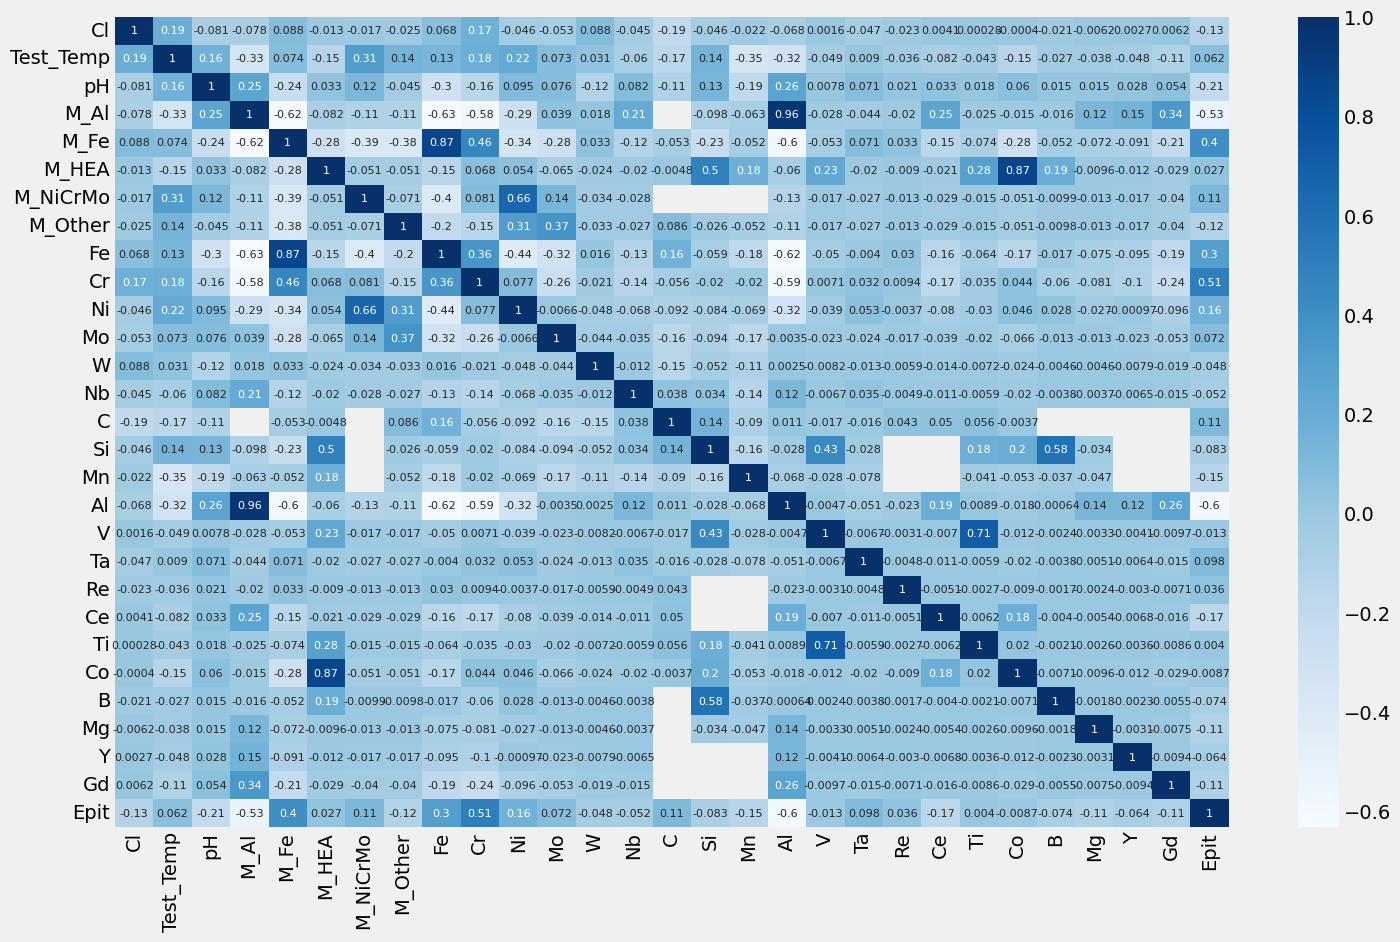

In [4]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(Alloy_Nan.corr(), ax=ax, cmap="Blues", annot=True, annot_kws={"fontsize":8})

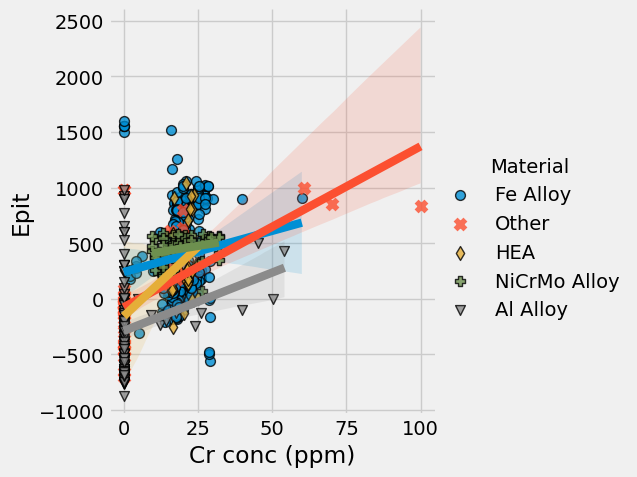

In [6]:
g= sns.lmplot(x="Cr", y= "Epit", hue = "Material", markers=["o", "x", "d", "P", "v"], scatter_kws= {"s": 50, "edgecolor":"black"}, data= Alloy_Nan)
g.set_titles(col_template='{col_name} Class'), g.set_xlabels("Cr conc (ppm)");

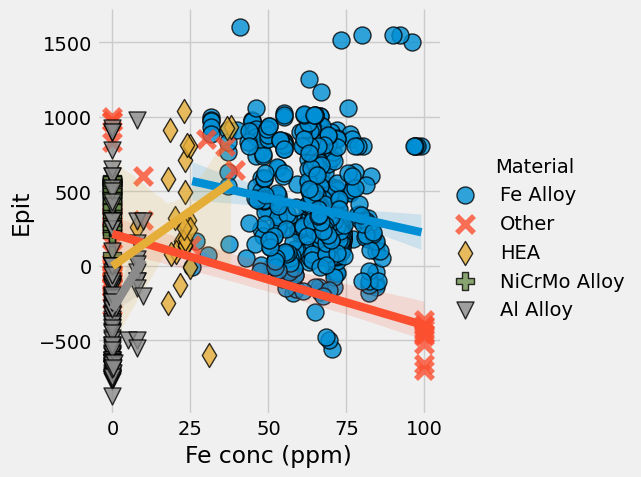

In [7]:
g= sns.lmplot(x="Fe", y= "Epit", hue = "Material", markers=["o", "x", "d", "P", "v"], scatter_kws= {"s": 150, "edgecolor":"black"}, data= Alloy_Nan)
g.set_titles(col_template='{col_name} Class'), g.set_xlabels("Fe conc (ppm)");

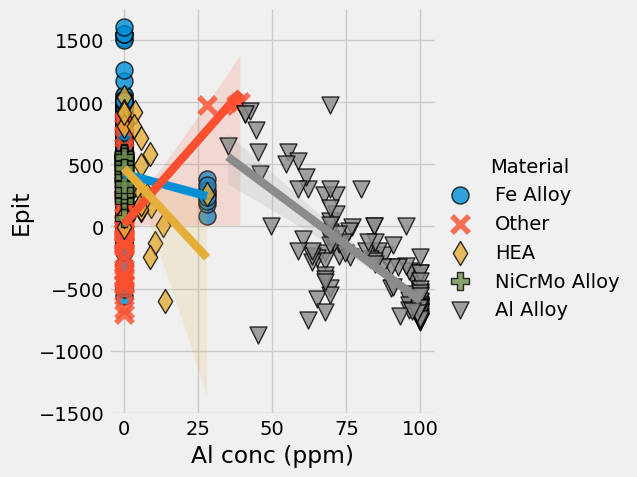

In [8]:
g= sns.lmplot(x="Al", y= "Epit", hue = "Material", markers=["o", "x", "d", "P", "v"], scatter_kws= {"s": 150, "edgecolor":"black"}, data= Alloy_Nan)
g.set_titles(col_template='{col_name} Class'), g.set_xlabels("Al conc (ppm)");

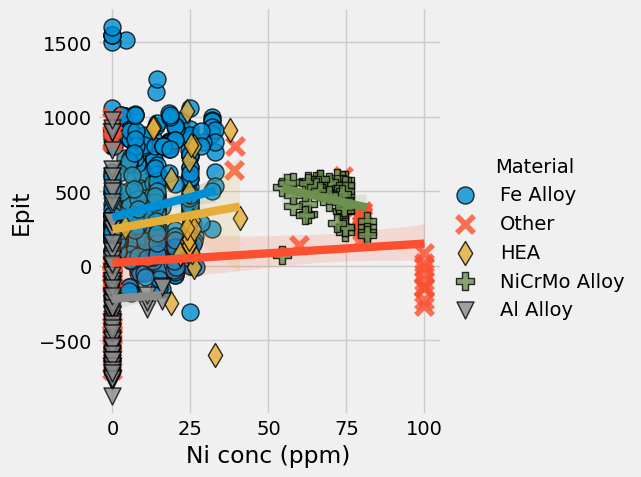

In [9]:
g= sns.lmplot(x="Ni", y= "Epit", hue = "Material", markers=["o", "x", "d", "P", "v"], scatter_kws= {"s": 150, "edgecolor":"black"}, data= Alloy_Nan)
g.set_titles(col_template='{col_name} Class'), g.set_xlabels("Ni conc (ppm)");

In the correlation matriz you can see that Cr is the most correlated with Epit followed by Fe.  Al got a negative -0.6

### Correlations amongst Metals

<AxesSubplot:>

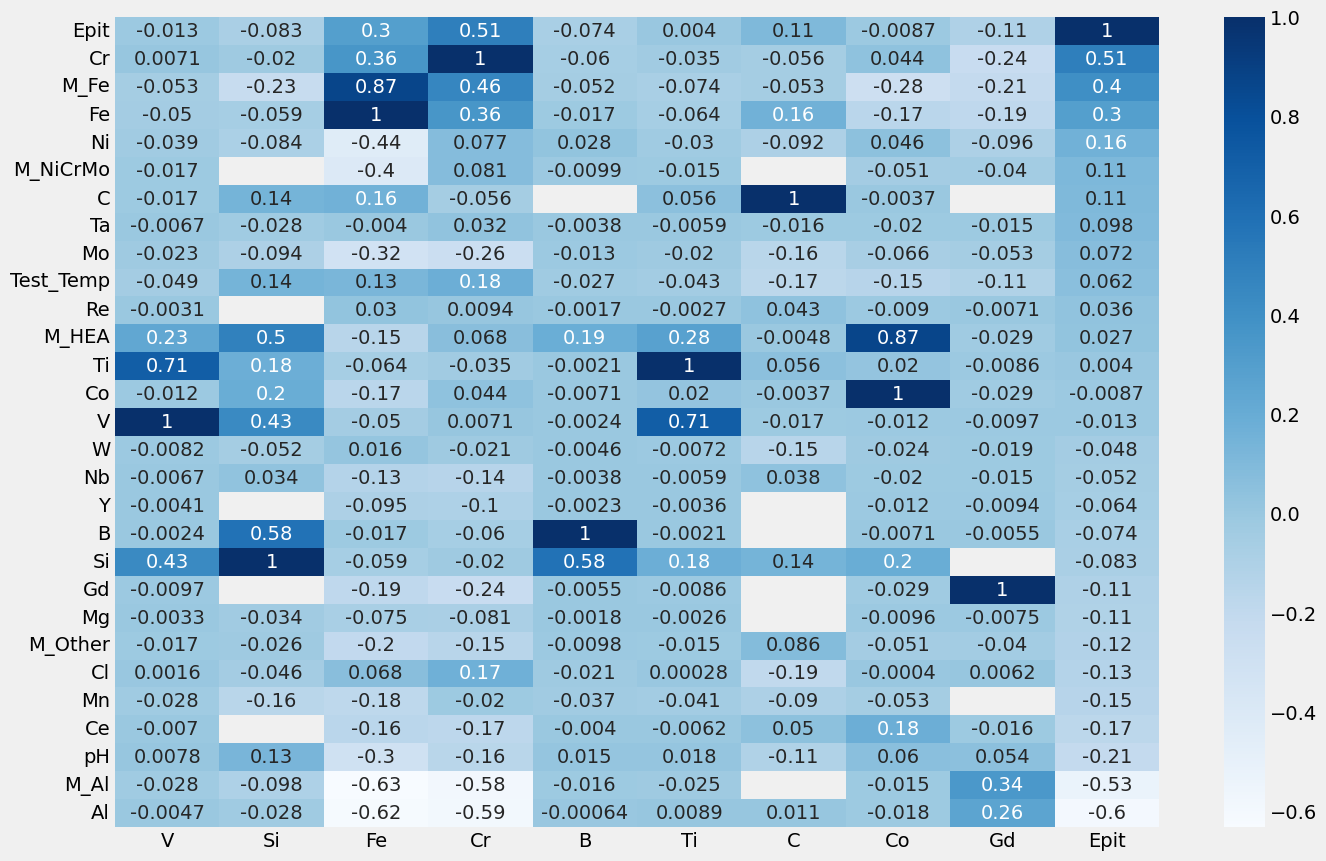

In [5]:
corr = Alloy_Nan.corr()[['V', 'Si', 'Fe', 'Cr', 'B', 'Ti', 'C', 'Co', 'Gd', 'Epit']].sort_values(by='Epit', ascending=False)
sns.heatmap(corr, cmap="Blues", annot=True)

(0.0, 60.0)

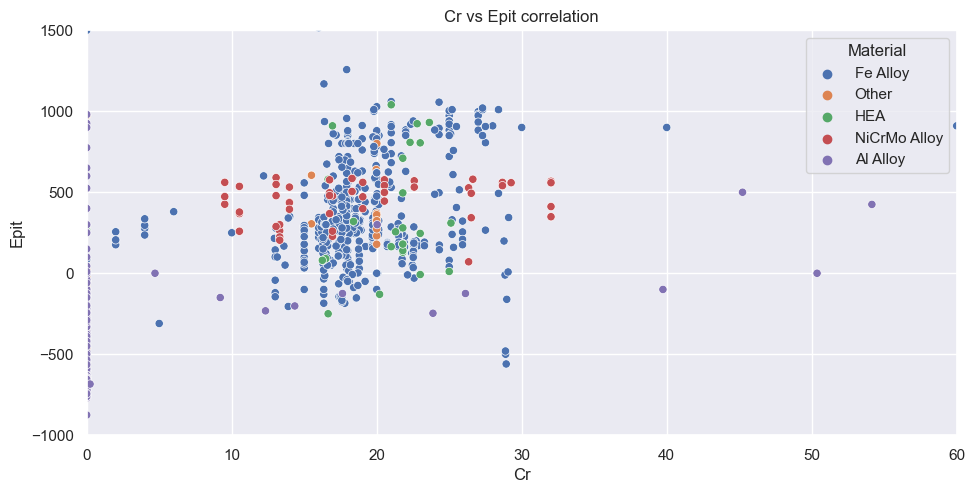

In [11]:
sns.set(rc ={"figure.figsize":(10,5)})
sns.scatterplot(data =Alloy_Nan, x = 'Cr' , y = 'Epit', color='blue'
               , hue = "Material" ).set(title='Cr vs Epit correlation')
plt.ylim(-1000, 1500)
plt.xlim(0, 60)

(0.0, 60.0)

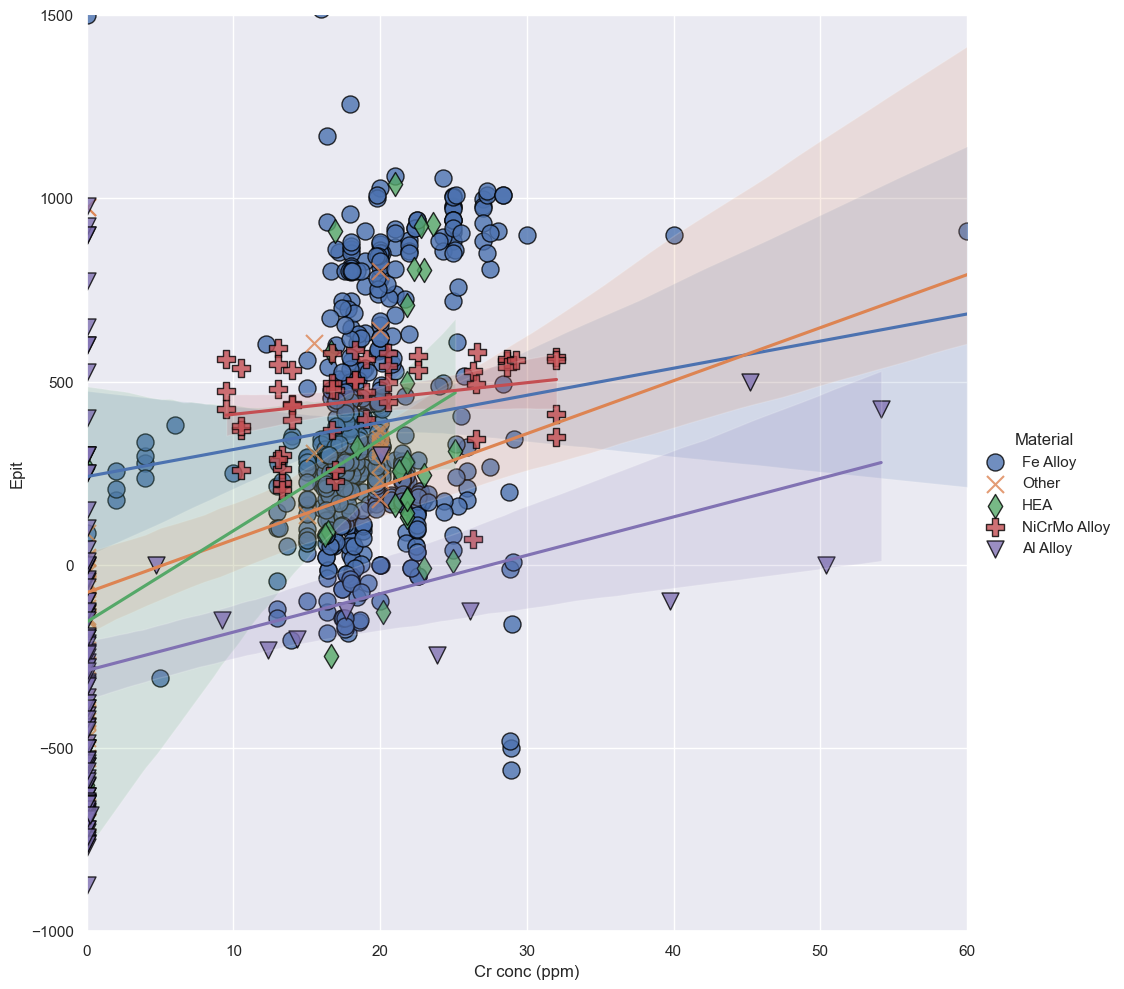

In [27]:
g= sns.lmplot(x="Cr", y= "Epit", hue = "Material", height=10, markers=["o", "x", "d", "P", "v"], scatter_kws= {"s": 150, "edgecolor":"black"}, data= Alloy_Nan)
g.set_titles(col_template='{col_name} Class'), g.set_xlabels("Cr conc (ppm)");
plt.ylim(-1000, 1500)
plt.xlim(0, 60)

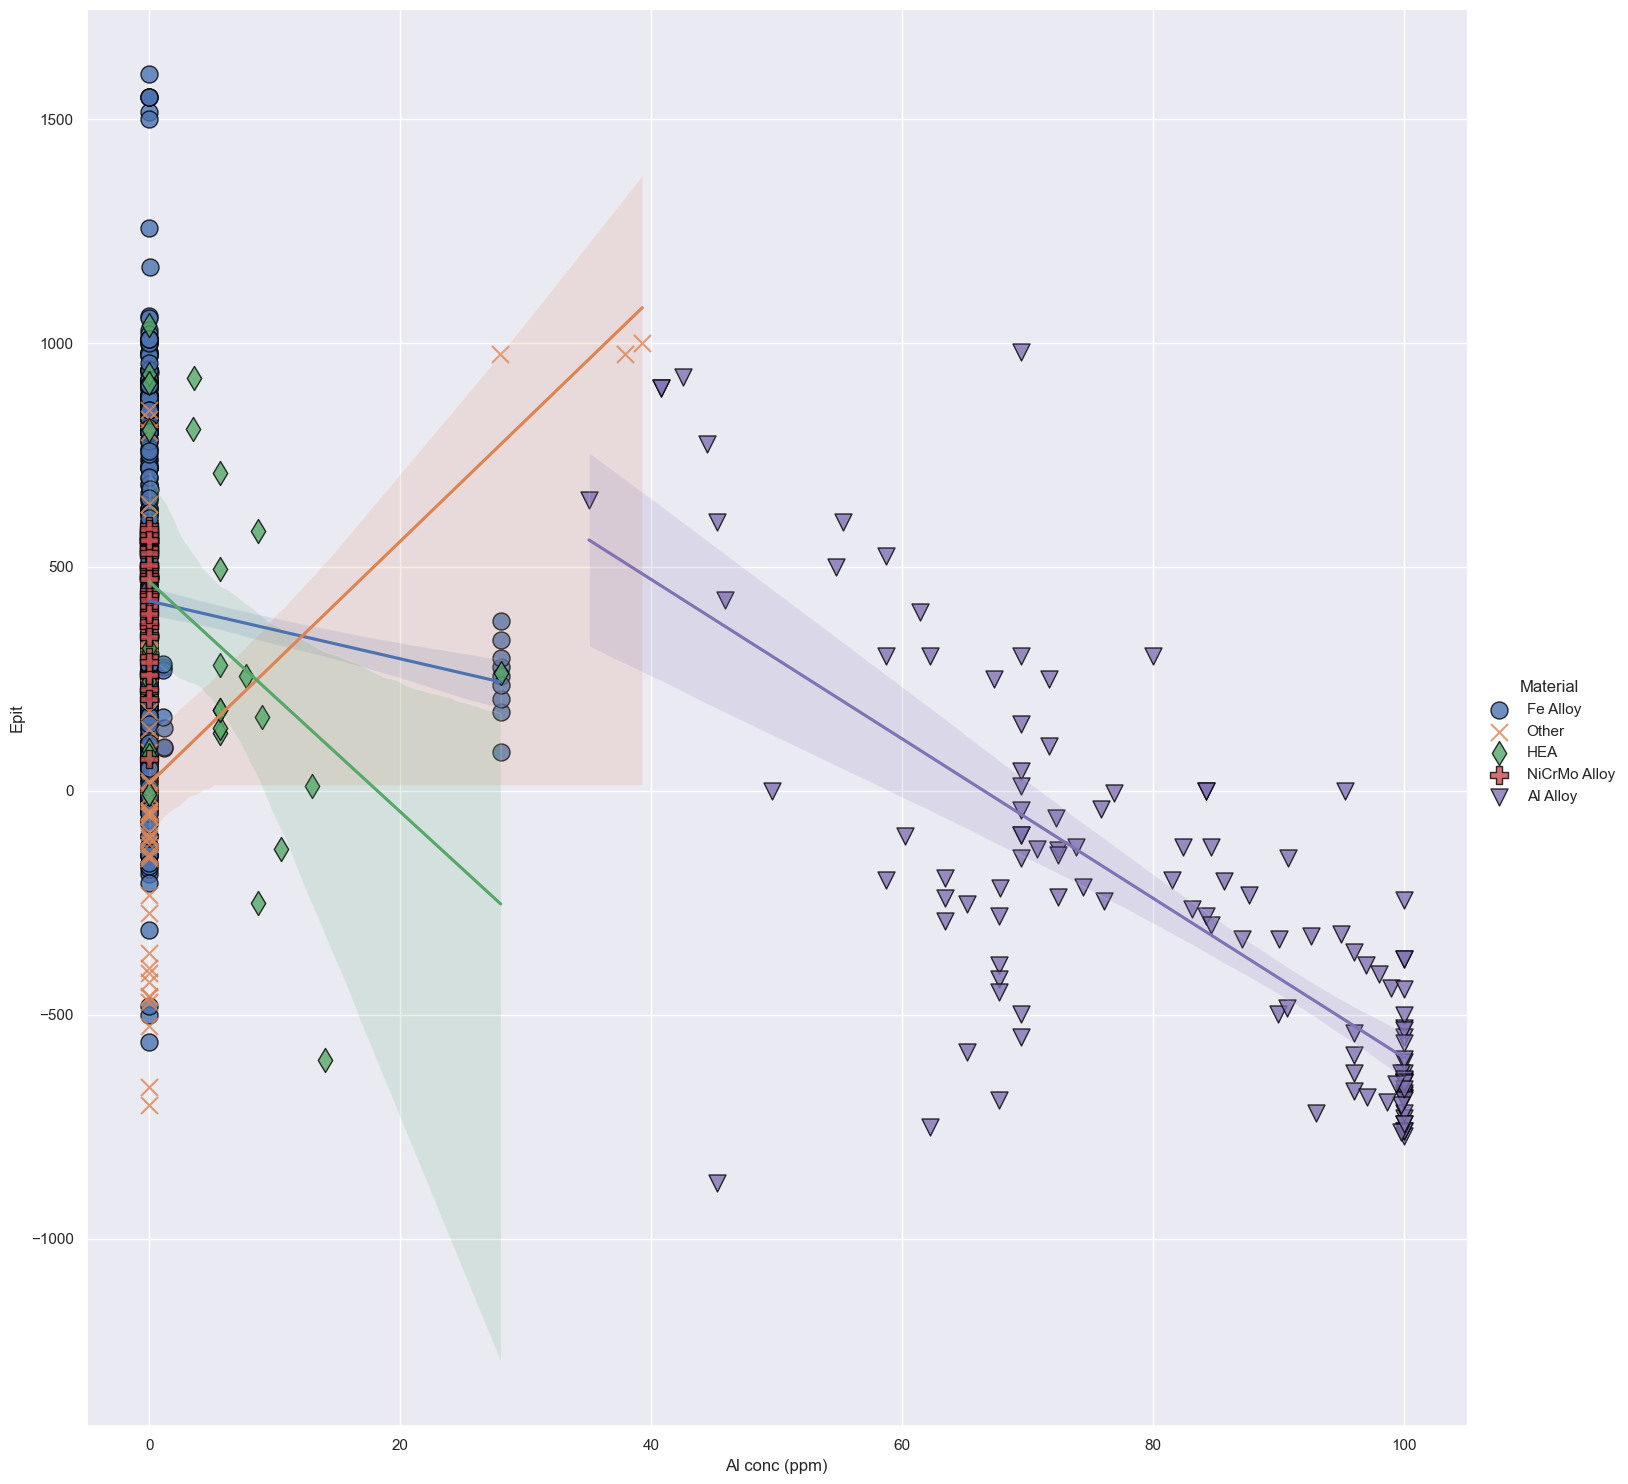

In [13]:
g= sns.lmplot(x="Al", y= "Epit", hue = "Material", height=15, markers=["o", "x", "d", "P", "v"], scatter_kws= {"s": 150, "edgecolor":"black"}, data= Alloy_Nan)
g.set_titles(col_template='{col_name} Class'), g.set_xlabels("Al conc (ppm)");

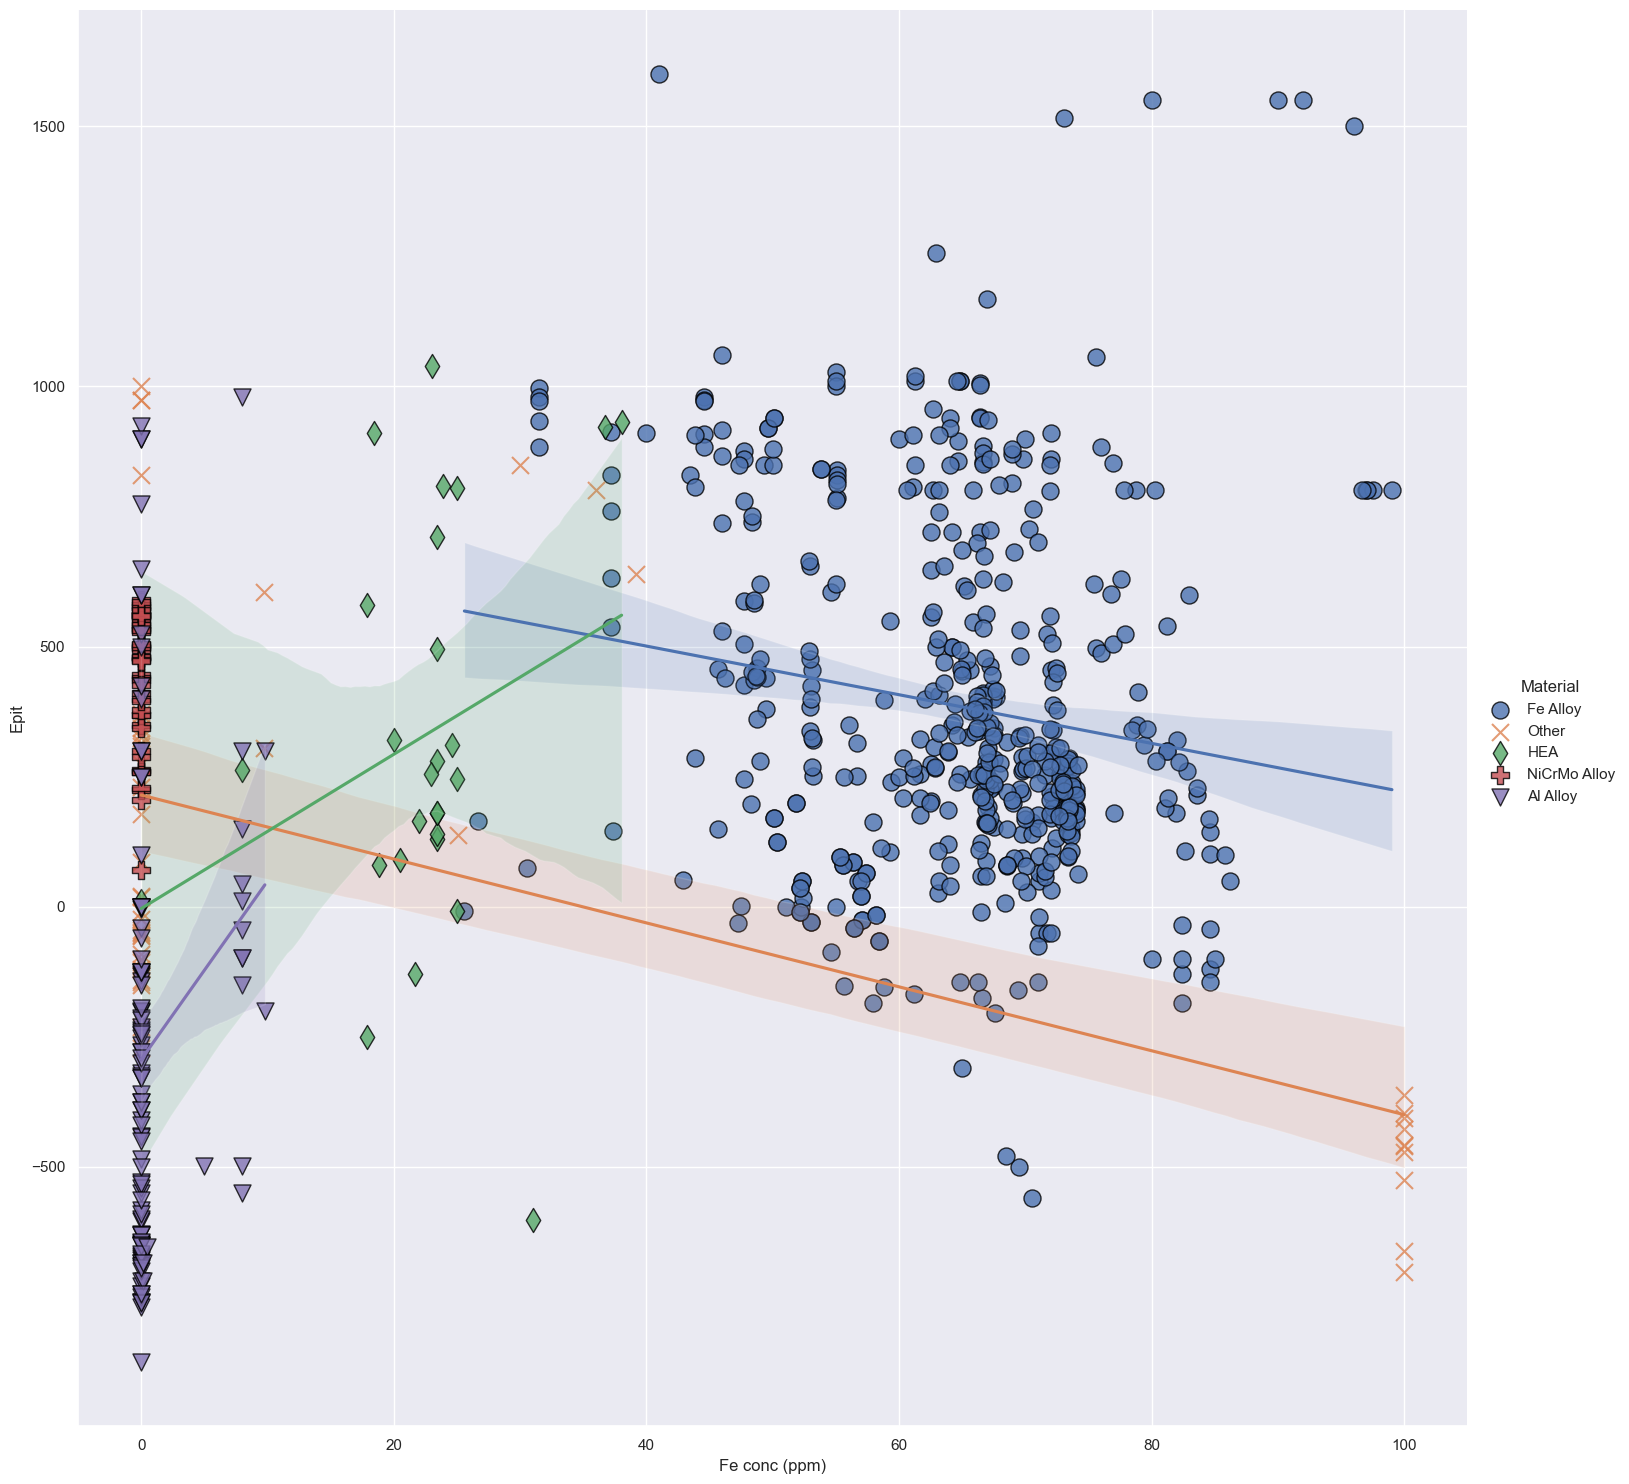

In [14]:
g= sns.lmplot(x="Fe", y= "Epit", hue = "Material", height=15, markers=["o", "x", "d", "P", "v"], scatter_kws= {"s": 150, "edgecolor":"black"}, data= Alloy_Nan)
g.set_titles(col_template='{col_name} Class'), g.set_xlabels("Fe conc (ppm)");

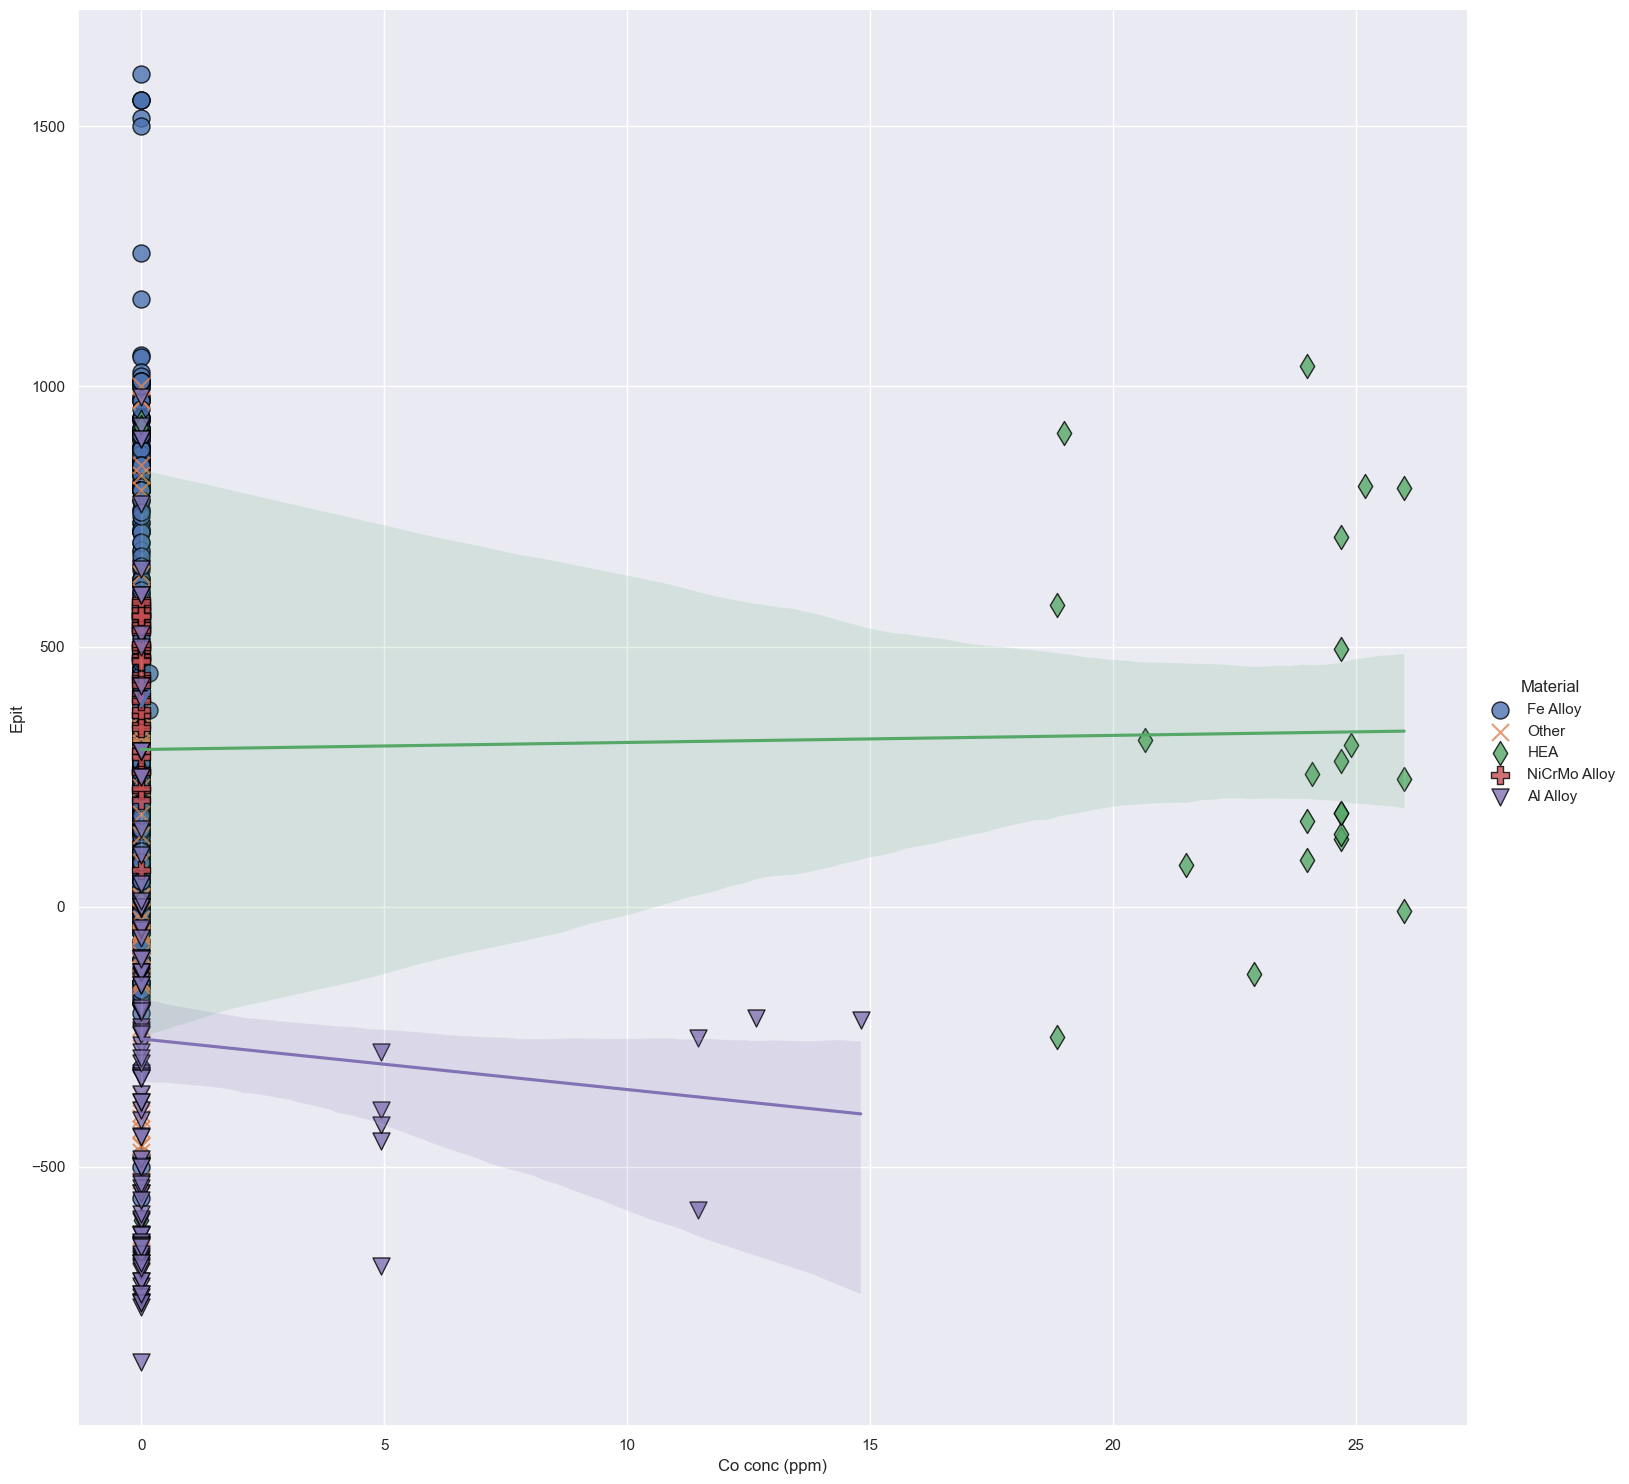

In [15]:
g= sns.lmplot(x="Co", y= "Epit", hue = "Material", height=15, markers=["o", "x", "d", "P", "v"], scatter_kws= {"s": 150, "edgecolor":"black"}, data= Alloy_Nan)
g.set_titles(col_template='{col_name} Class'), g.set_xlabels("Co conc (ppm)");

<AxesSubplot:xlabel='Fe', ylabel='Epit'>

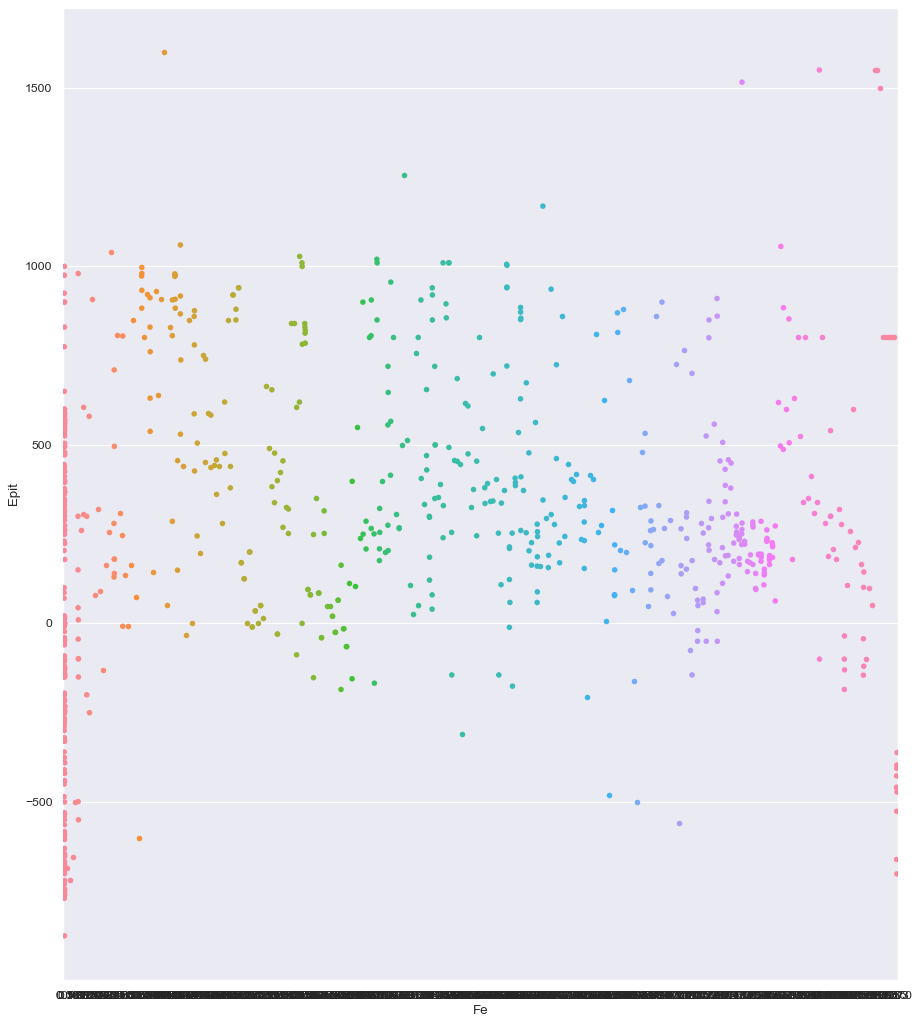

In [16]:
fig, ax=plt.subplots(figsize=(12,15), dpi=80)
sns.stripplot(Alloy_Nan.Fe, Alloy_Nan.Epit, ax=ax)

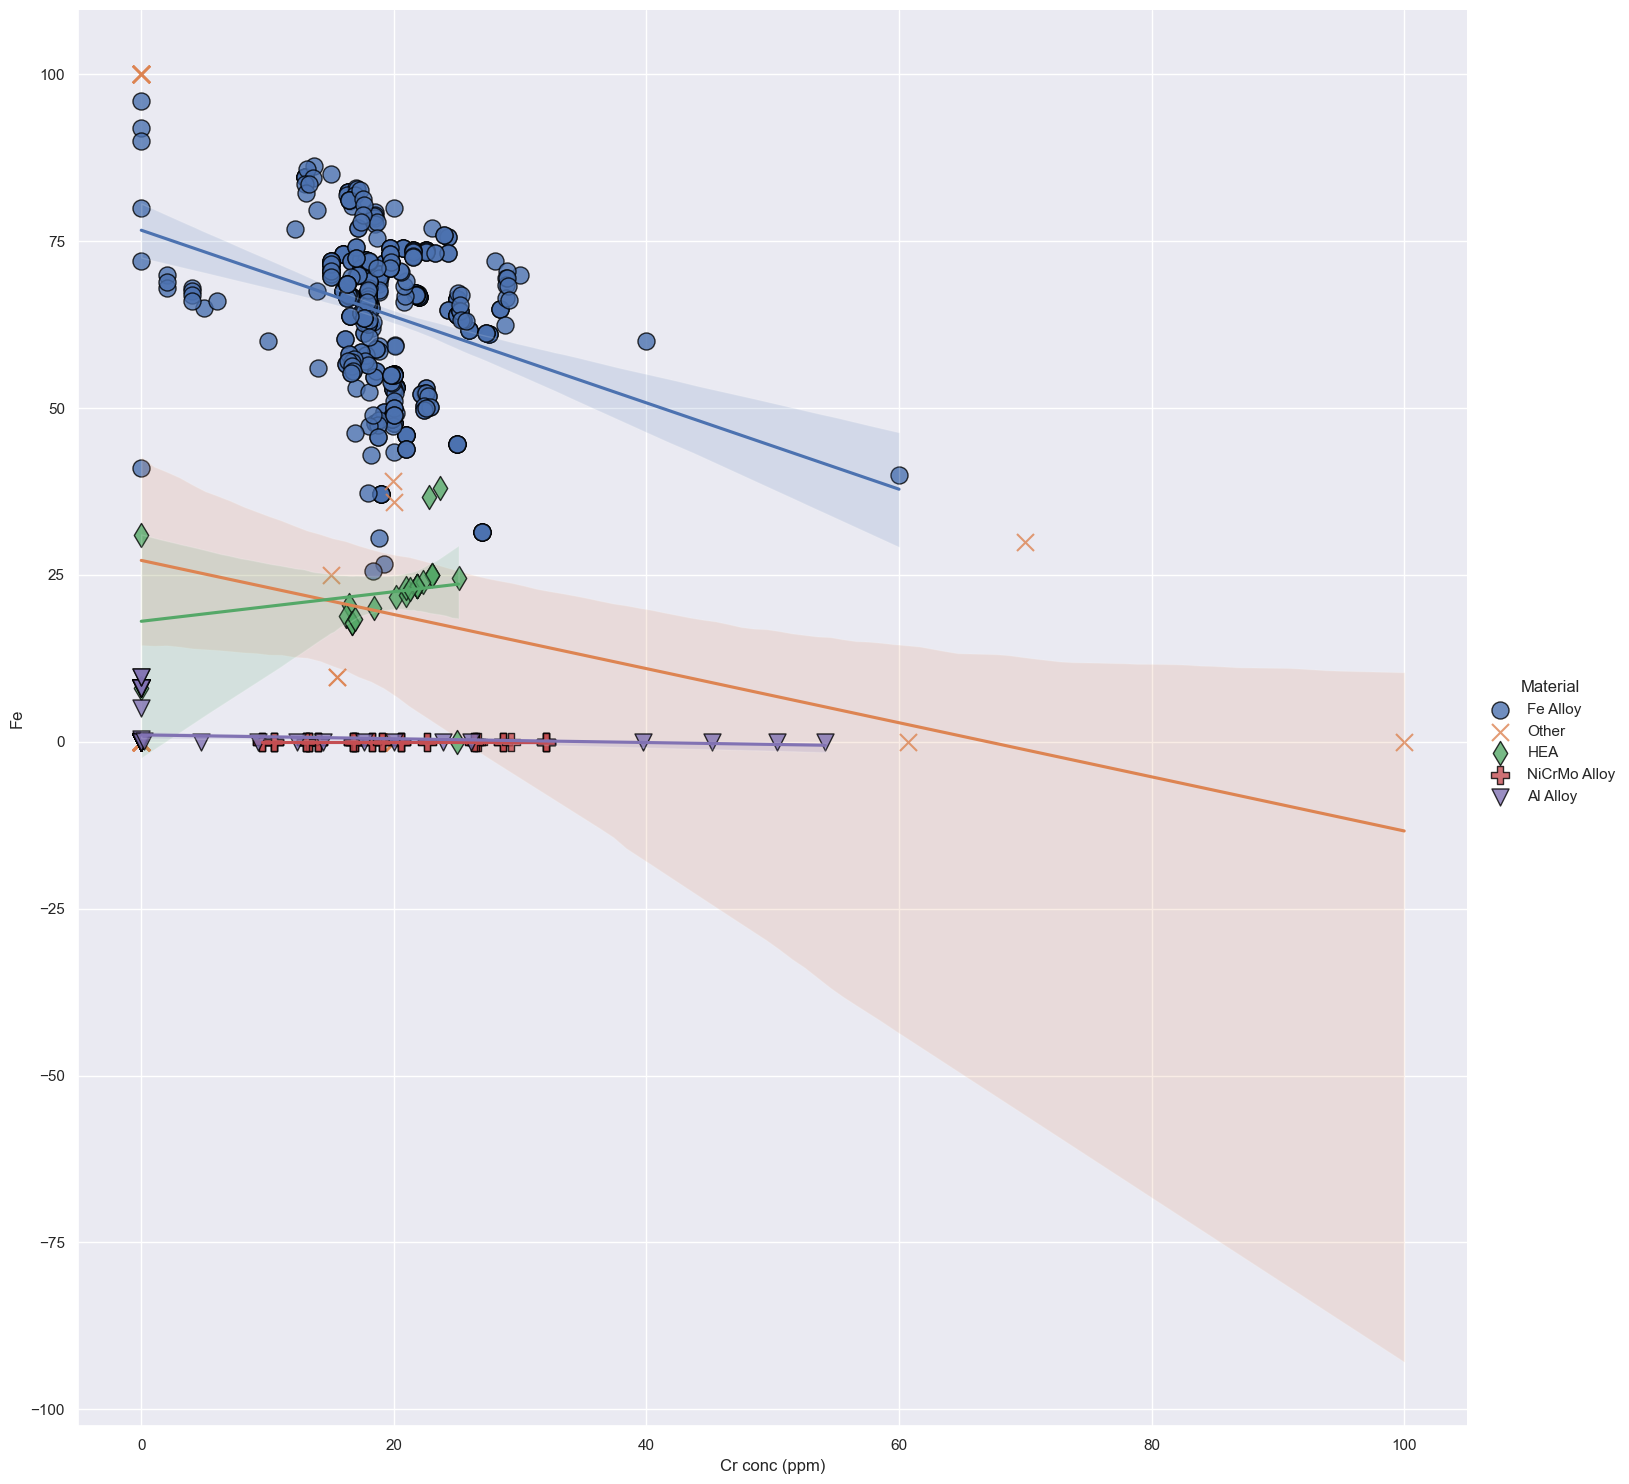

In [17]:
g= sns.lmplot(x="Cr", y= "Fe", hue = "Material", height=15, markers=["o", "x", "d", "P", "v"], scatter_kws= {"s": 150, "edgecolor":"black"}, data= Alloy_Nan)
g.set_titles(col_template='{col_name} Class'), g.set_xlabels("Cr conc (ppm)");

In [18]:
Plot_Alloy_Nan= Alloy_Nan[['V', 'Ni', 'Si', 'Fe', 'Cr', 'B', 'Ti', 'C', 'Co', 'Epit', 'Material']]

<Figure size 800x640 with 0 Axes>

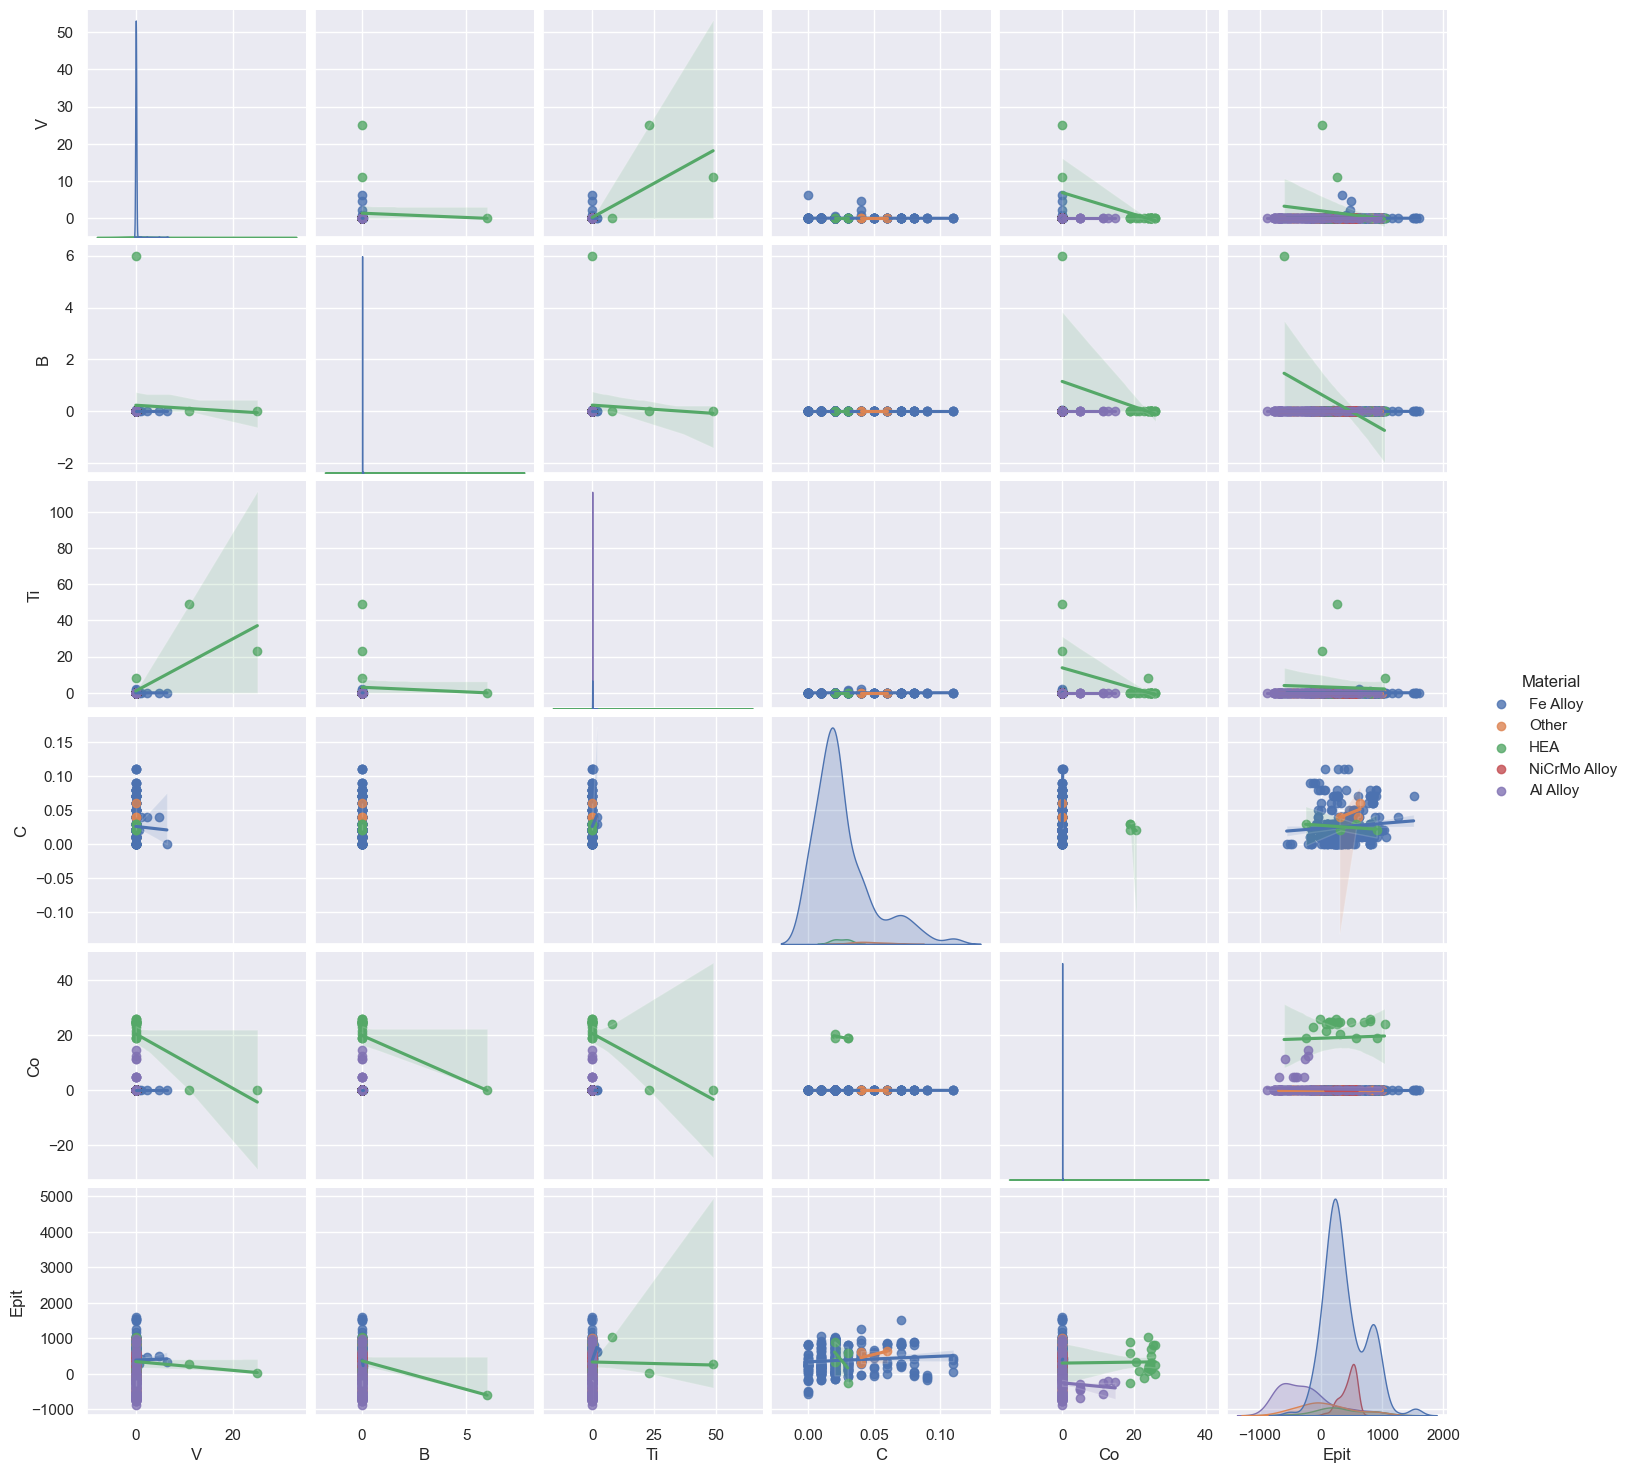

In [19]:
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(Alloy_Nan[['V', 'B', 'Ti', 'C', 'Co', 'Epit', 'Material']], kind='reg', hue='Material')
plt.show()

<Figure size 800x640 with 0 Axes>

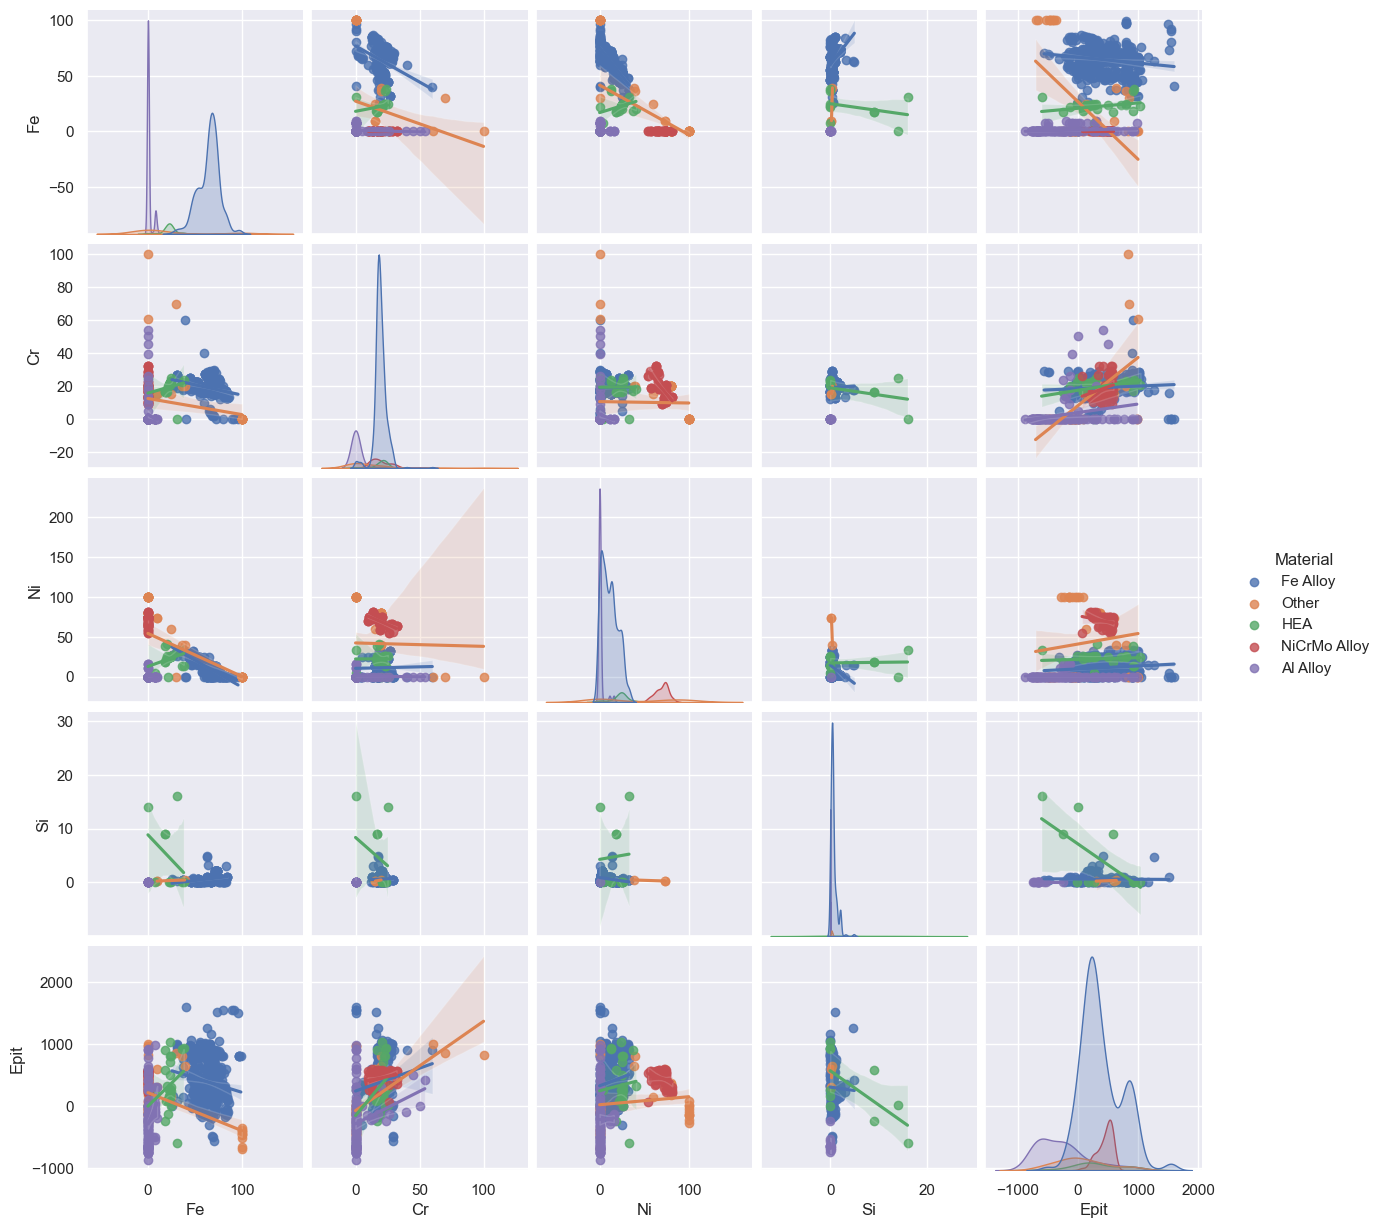

In [20]:
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(Alloy_Nan[['Fe', 'Cr', 'Ni', 'Si', 'Epit', 'Material']], kind='reg', hue='Material')
plt.show()

(0.0, 80.0)

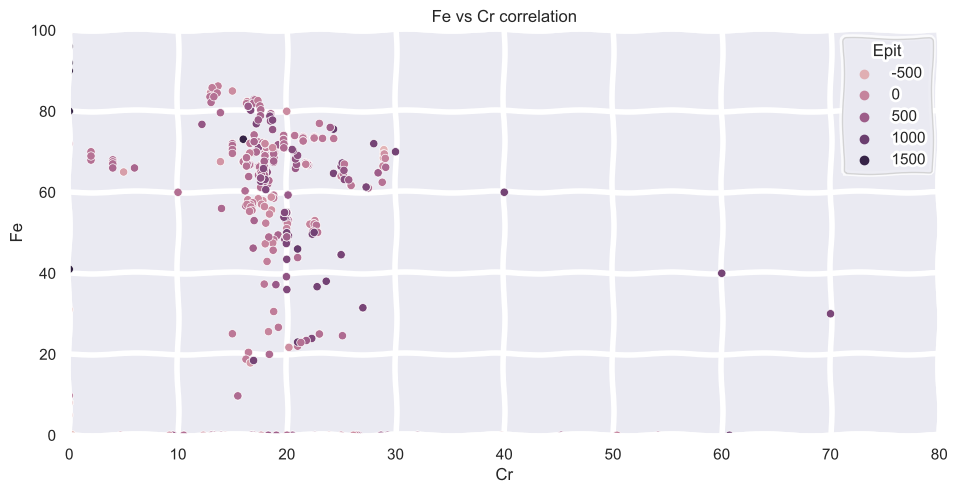

In [33]:

sns.set(rc ={"figure.figsize":(10,5)})
sns.scatterplot(data =Alloy_Nan, x = 'Cr' , y = 'Fe', color='blue'
                , hue = "Epit").set(title='Fe vs Cr correlation')
plt.ylim(0, 100)
plt.xlim(0, 80)

In [22]:
Alloy_Nan.columns

Index(['Cl', 'Test_Temp', 'pH', 'M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo', 'M_Other',
       'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta',
       'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'Epit', 'Material'],
      dtype='object')

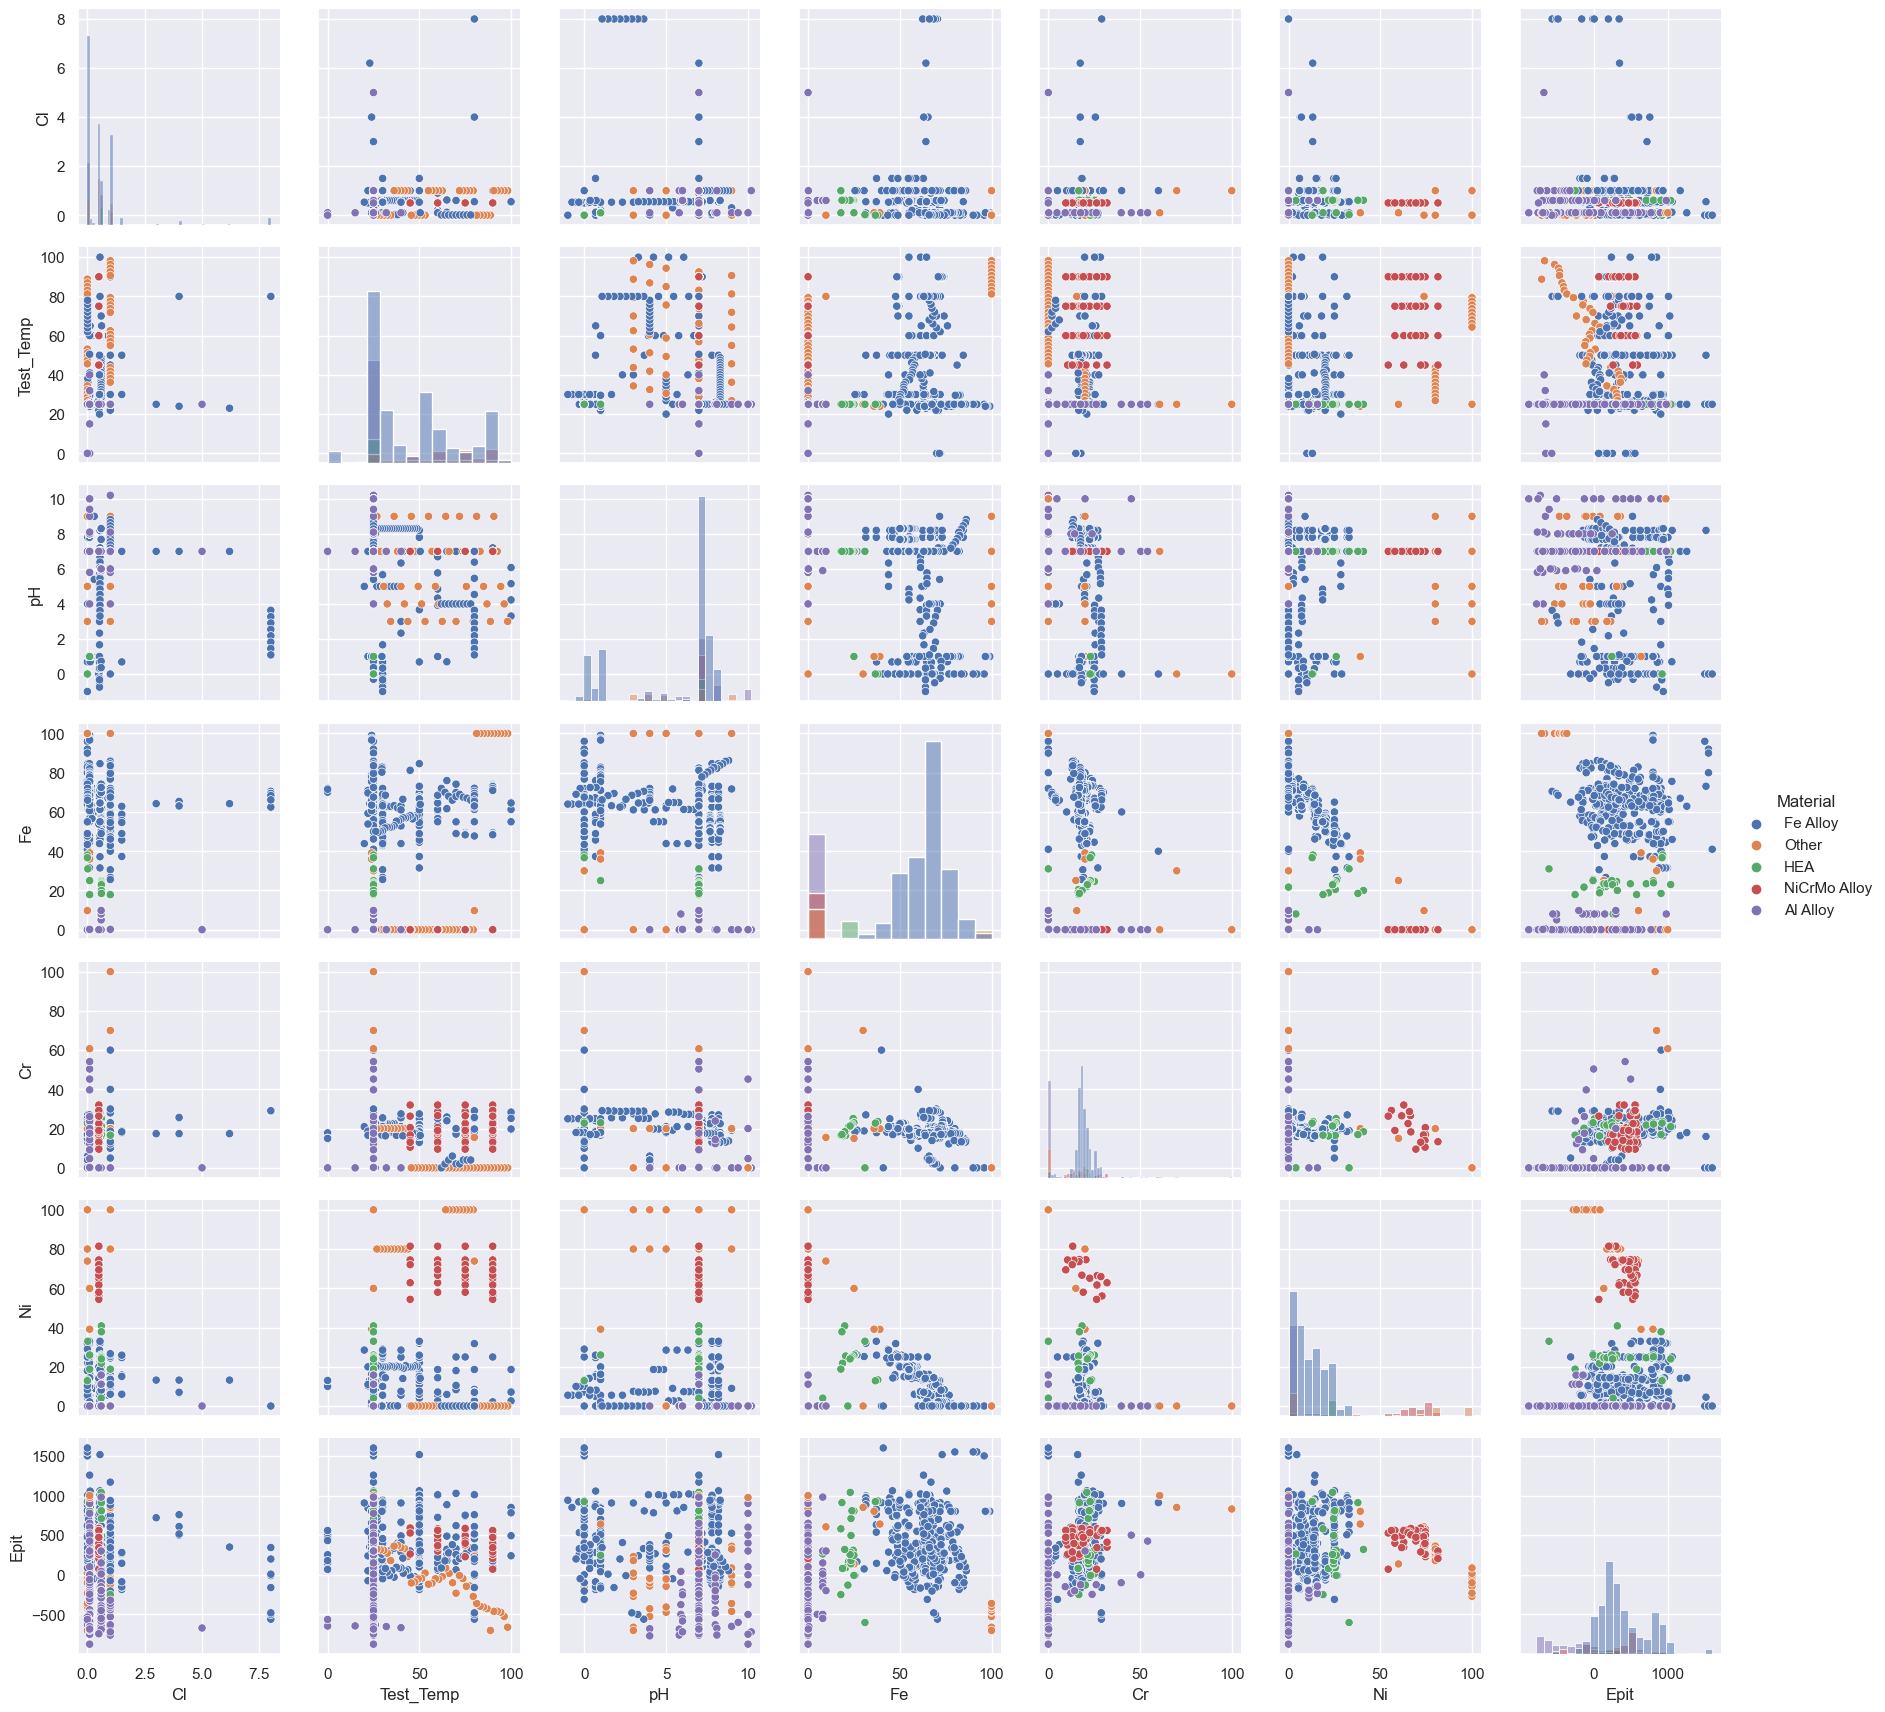

In [23]:
g = sns.PairGrid(Alloy_Nan[['Cl', 'Test_Temp', 'pH', 'Fe', 'Cr', 'Ni',  'Epit', 'Material']], hue="Material")
g.map_diag(sns.histplot)#'Mo', 'Si', 'Mn', 'Al','Ti', 'Co', 'B', 'Mg',
g.map_offdiag(sns.scatterplot)
g.add_legend()

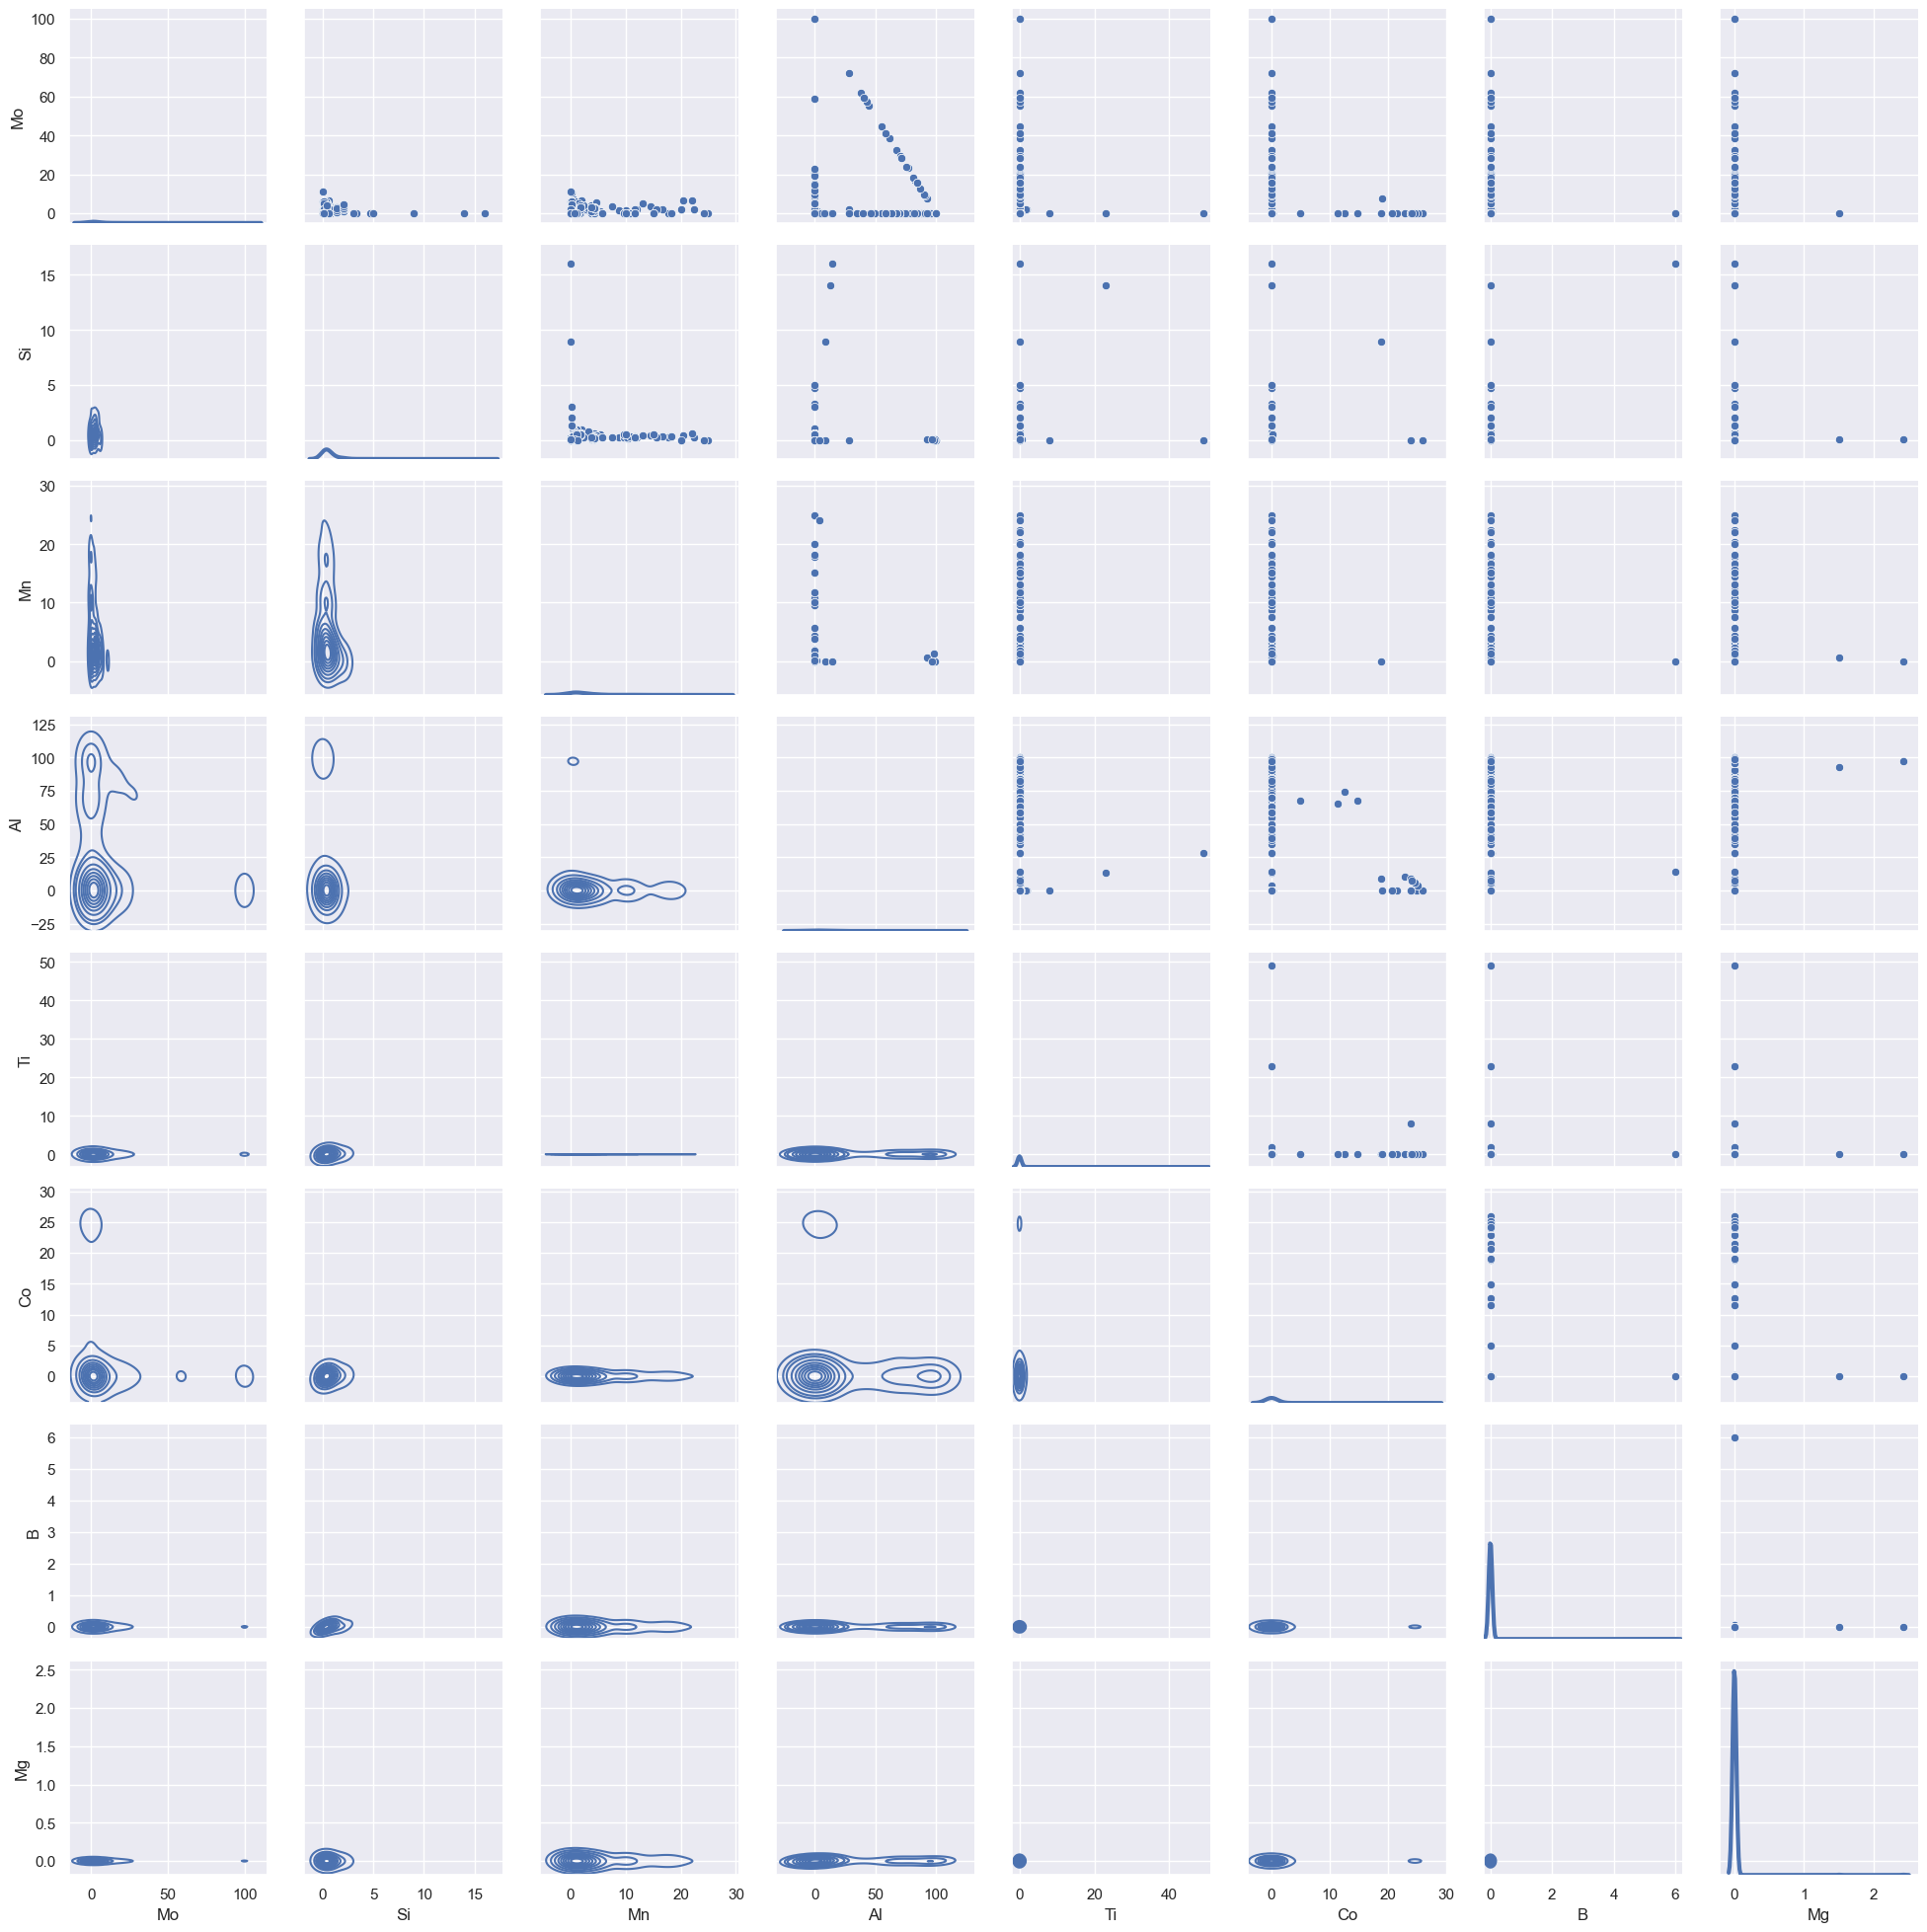

In [24]:
g = sns.PairGrid(Alloy_Nan[['Mo', 'Si', 'Mn', 'Al','Ti', 'Co', 'B', 'Mg']])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

In [25]:
Metal_Cor= Alloy_Nan[['Fe', 'Cr', 'Ni', 'Mo', 'Co', 'Epit', 'Material']]

IndexError: index 4 is out of bounds for axis 0 with size 4

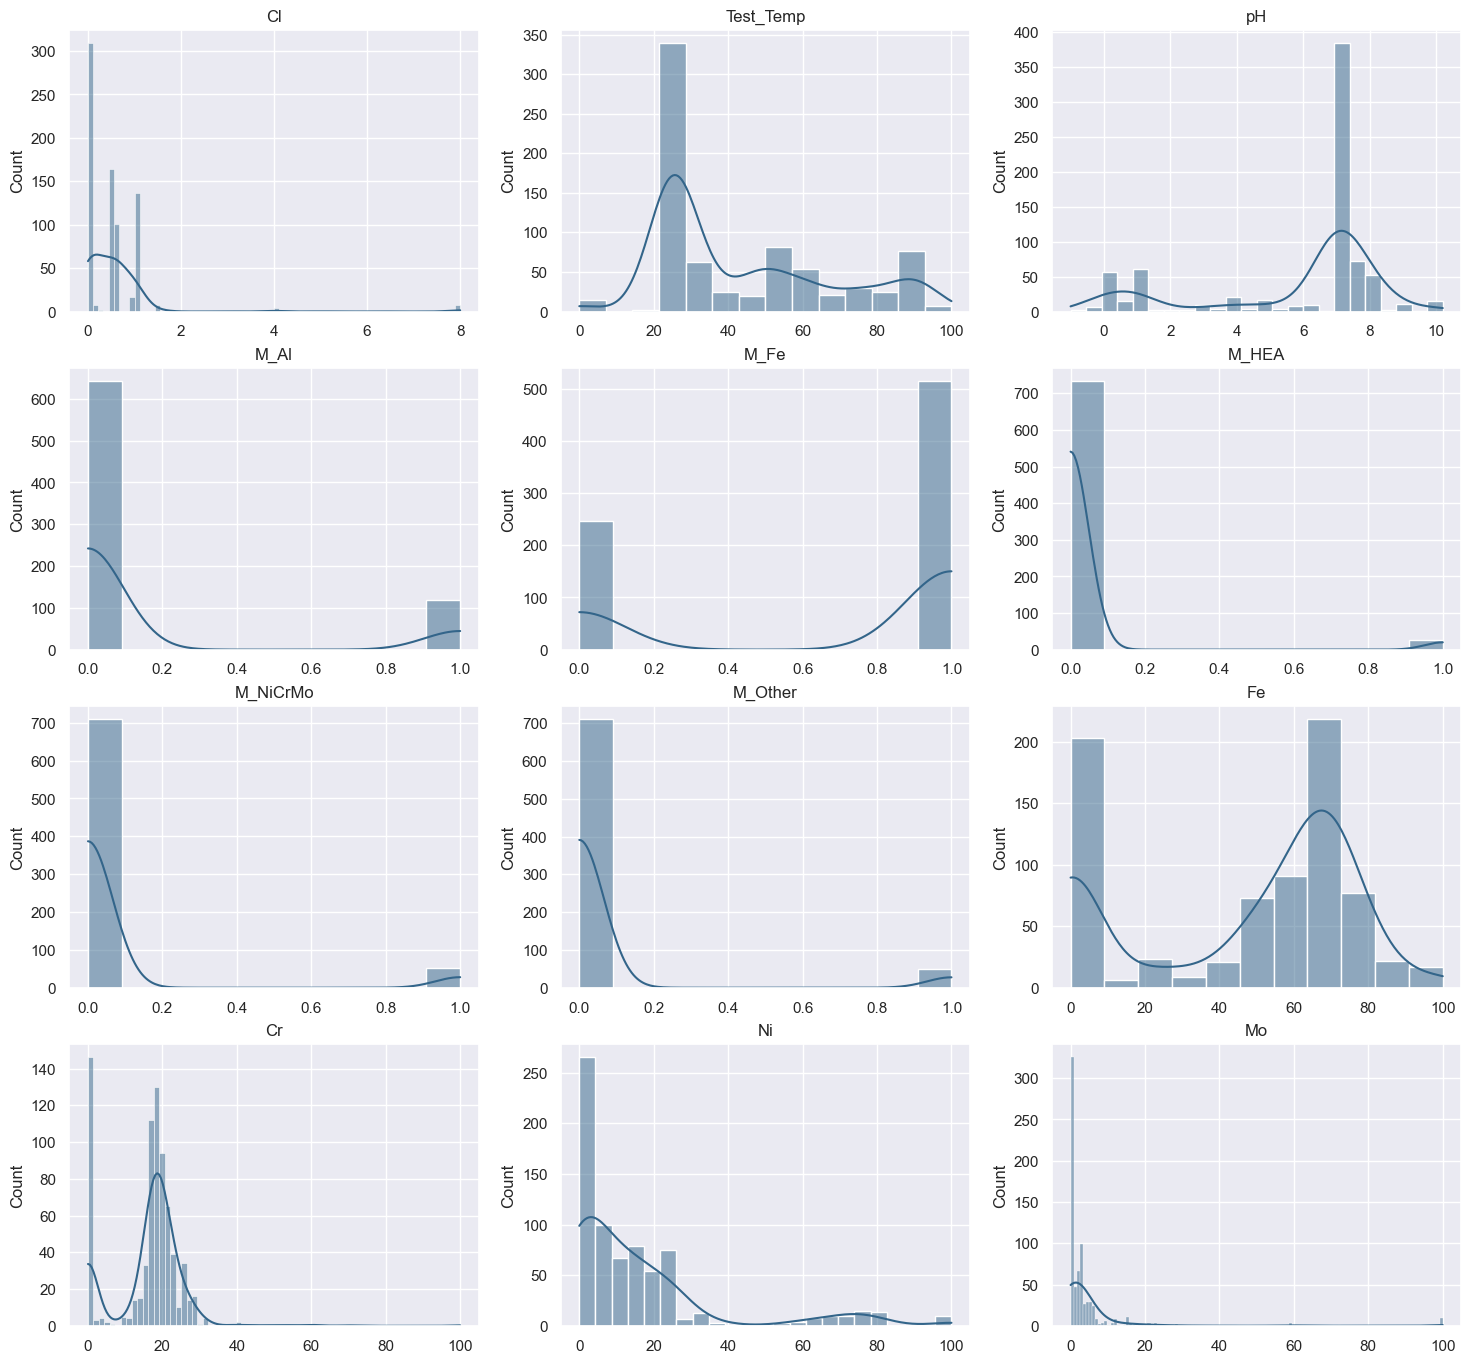

In [26]:
    # Plot histograms for features
fig,ax = plt.subplots(4,3,figsize=(16,16))
count = 0
for item in Alloy_Nan.columns.tolist():
        sns.histplot(Alloy_Nan[item], kde=True,ax=ax[int(count/3)][count%3], color='#33658A').set(title=item, xlabel='')
        count += 1
ax.flat[-1].set_visible(False)
ax.flat[-2].set_visible(False)
fig.tight_layout(pad=3)

To make a better approximation on inputing the NAN values, I will have to look at the Alloy tipe column, so to know how much of the element is suppose to be on this alloy and therefore try to inpute it with a linear regression base on normal occurence of the metal by alloy

## Trainining the model and tracking with MLFlow

In [ ]:
'''#First you have to create a file call uri something and then run the code at the start of import libraries
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(open("../.mlflow_uri").read().strip())
mlflow.set_experiment("Simple_LR_SImpute")
mlflow.start_run()
run = mlflow.active_run()'''

MlflowException: API request to endpoint /api/2.0/mlflow/experiments/get-by-name failed with error code 403 != 200. Response body: ''

In [ ]:
'''print("Active run_id: {}".format(run.info.run_id))'''

'print("Active run_id: {}".format(run.info.run_id))'

# Error Analysis

In [ ]:
### Defining X and y
X1 = Alloy_Null.drop(["Epit", "Material"], axis=1)
y1 = Alloy_Null["Epit"]

## Splitting data for testing 

Raw Data Alloy_Null is with interpolation to cero

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=42)
#stratify=y throws an error refering to the y being too little of one of the two choices, but actually y has lots of choices

In [ ]:
X1_train.columns

Index(['Cl', 'Test_Temp', 'pH', 'M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo', 'M_Other',
       'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta',
       'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd'],
      dtype='object')

## Feature scaling

In [ ]:
# You have to define which columns you want to scale, in this case, all the metals ions
col_scale_1 = ['Cl', 'Test_Temp', 'pH', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta','Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd']
#X1_train= X1_train.drop(col_scale) axis=1)

### Data Normalisation

In [ ]:
# Scaling with MinMaxScaler
scaler_1= MinMaxScaler()
X1_train_scaled= scaler_1.fit_transform(X1_train[col_scale_1])
X1_test_scaled= scaler_1.transform(X1_test[col_scale_1])

In [ ]:
#X1_test_scaled.columns=['Cl', 'Test_Temp', 'pH', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta','Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd']
# Concatenating scaled and dummy columns 
X1_train_preprocessed= np.concatenate([X1_train_scaled, X1_train.drop(col_scale_1, axis=1)], axis=1)
X1_test_preprocessed= np.concatenate([X1_test_scaled, X1_test.drop(col_scale_1, axis=1)], axis=1)

### Multiple Linear Regression __Epit_Sinpu Simple Imputer in the Ions__

In [ ]:
# Fit linear regression model
lin_reg1 = LinearRegression()
#Cross validating
score1= cross_val_score(lin_reg1, X1_train_preprocessed, y1_train, cv=5) #n_jobs=-1
#fixing the model with a lr
lin_reg1.fit(X1_train_preprocessed, y1_train)
#training the model
y1_pred_tr = lin_reg1.predict(X1_train_preprocessed)
#predicting on a test sample
y_pred= lin_reg1.predict(X1_test_preprocessed)

In [ ]:
y1_pred_tr.shape
y_pred.shape
score1

array([  0.3736416 ,   0.6120767 ,   0.53875856, -41.18378137,
         0.45951955])

In [ ]:
# Now we calculate intercept and coefficient
intercept = lin_reg1.intercept_
coefficients = lin_reg1.coef_
print("Intercept:", intercept.round(2))
print("Coefficients:", coefficients.round(2))

Intercept: 152.69
Coefficients: [-776.61  -94.12 -227.92  105.47 1446.5   618.85 1151.23 -533.36  256.43
   25.56 -787.29 -497.35 -542.16 -177.69  207.74  153.03  125.73   96.7
 -621.76 -524.46 -235.61  105.47  408.5    96.62   83.47  587.69 -253.62
 -514.16]


In [ ]:
residual_1 = y1_test - y_pred
#compute mean residuals
np.mean(residual_1)

19.948656030636556

In [ ]:
# evaluate model accuracy
#Model Metrics
print("MAE in Test Multi_LR with Null x_train", mean_absolute_error(y1_test, y_pred).round(3))
print("RMSE in Test Multi_LR with Null x_train", mean_squared_error(y1_test, y_pred, squared=False).round(3))
print("R2 for Multi_LR with Null x_train", r2_score(y1_test, y_pred).round(3))

MAE in Test Multi_LR with Null x_train 250.549
RMSE in Test Multi_LR with Null x_train 327.543
R2 for Multi_LR with Null x_train 0.389


In [ ]:
# Now we calculate intercept and coefficient
intercept = lin_reg1.intercept_
coefficients = lin_reg1.coef_
print("Intercept:", intercept.round(2))
print("Coefficients:", coefficients.round(2))

Intercept: 152.69
Coefficients: [-776.61  -94.12 -227.92  105.47 1446.5   618.85 1151.23 -533.36  256.43
   25.56 -787.29 -497.35 -542.16 -177.69  207.74  153.03  125.73   96.7
 -621.76 -524.46 -235.61  105.47  408.5    96.62   83.47  587.69 -253.62
 -514.16]


## With NN imputation 
Alloy_NN_Ma= pd.read_csv("../data/Alloy_NN_Ma.csv")

In [ ]:
Corr_Finalia = pd.read_csv("../data/Corrosion_Finalia.csv")
Corr_Finalia= Corr_Finalia.drop("Epit", axis=1)
Corr_Finalia.columns

Index(['Cl', 'Test_Temp', 'pH', 'M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo',
       'M_Other'],
      dtype='object')

In [ ]:
Alloy_NN_Ma= Alloy_NN_Ma.drop("Material", axis=1)

In [ ]:
Alloy_NN= pd.concat([Corr_Finalia, Alloy_NN_Ma], axis=1 )
Alloy_NN.columns

Index(['Cl', 'Test_Temp', 'pH', 'M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo', 'M_Other',
       'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta',
       'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'Epit'],
      dtype='object')

In [ ]:
### Defining X and y
y3= Alloy_NN["Epit"]
X3 = Alloy_NN.drop(["Epit"], axis=1)
#spliting 
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.20, random_state=42)

#scale features
col_scale_3 = ['Cl', 'Test_Temp', 'pH', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta','Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd']

# Scaling with MinMaxScaler
scaler_3= MinMaxScaler()
X3_train_scaled= scaler_3.fit_transform(X3_train[col_scale_3])
X3_test_scaled= scaler_3.transform(X3_test[col_scale_3])

#X1_test_scaled.columns=['Cl', 'Test_Temp', 'pH', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta','Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd']
# Concatenating scaled and dummy columns 
X3_train_preprocessed= np.concatenate([X3_train_scaled, X3_train.drop(col_scale_3, axis=1)], axis=1)
X3_test_preprocessed= np.concatenate([X3_test_scaled, X3_test.drop(col_scale_3, axis=1)], axis=1)

# Fit linear regression model
lin_reg3 = LinearRegression()
#Cross validating
score3 = cross_val_score(lin_reg3, X3_train_preprocessed, y3_train, cv=5) #n_jobs=-1
#fixing the model with a lr
lin_reg3.fit(X3_train_preprocessed, y3_train)
#training the model
y3_pred_tr = lin_reg3.predict(X3_train_preprocessed)
#predicting on a test sample
y3_pred= lin_reg3.predict(X3_test_preprocessed)

#Model Metrics
print("MAE in Test Multi_LR with Null x_train", mean_absolute_error(y3_test, y3_pred).round(3))
print("RMSE in Test Multi_LR with Null x_train", mean_squared_error(y3_test, y3_pred, squared=False).round(3))
print("R2 for Multi_LR with Null x_train", r2_score(y3_test, y3_pred).round(3))
print("RMSE/MAE", (mean_squared_error(y3_test, y3_pred, squared=False).round(3))/(mean_absolute_error(y3_test, y3_pred).round(3)))

MAE in Test Multi_LR with Null x_train 250.383
RMSE in Test Multi_LR with Null x_train 328.691
R2 for Multi_LR with Null x_train 0.385
RMSE/MAE 1.3127528626144744


### Comparing imputation with Interpolation in whole Matriz

In [ ]:
Alloy_Inter_Ma= Alloy_Inter_Ma.fillna(0)

In [ ]:
Alloy_Inter_Ma.columns

Index(['Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta',
       'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'Epit', 'Material'],
      dtype='object')

In [ ]:
#Alloy_Inter_Ma= Alloy_Inter_Ma.drop("Material", axis=1)

In [ ]:
Corr_Finalia = pd.read_csv("../data/Corrosion_Finalia.csv")
Corr_Finalia= Corr_Finalia.drop("Epit", axis=1)

#Alloy_Inter_Ma = Alloy_Inter_Ma.drop("Material", axis=1)
Alloy_Inter= pd.concat([Corr_Finalia, Alloy_Inter_Ma], axis=1 )

### Defining X and y
y4= Alloy_Inter["Epit"]
X4 = Alloy_Inter.drop(["Epit"], axis=1)
#spliting 
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.20, random_state=42)

#scale features
col_scale_4 = ['Cl', 'Test_Temp', 'pH', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta','Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd']

# Scaling with MinMaxScaler
scaler_4= MinMaxScaler()
X4_train_scaled= scaler_4.fit_transform(X4_train[col_scale_4])
X4_test_scaled= scaler_4.transform(X4_test[col_scale_4])

#X1_test_scaled.columns=['Cl', 'Test_Temp', 'pH', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta','Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd']
# Concatenating scaled and dummy columns 
X4_train_preprocessed= np.concatenate([X4_train_scaled, X4_train.drop(col_scale_4, axis=1)], axis=1)
X4_test_preprocessed= np.concatenate([X4_test_scaled, X4_test.drop(col_scale_4, axis=1)], axis=1)

# Fit linear regression model
lin_reg4 = LinearRegression()
#Cross validating
score4 = cross_val_score(lin_reg4, X4_train_preprocessed, y4_train, cv=5) #n_jobs=-1
#fixing the model with a lr
lin_reg4.fit(X4_train_preprocessed, y4_train)
#training the model
y4_pred_tr = lin_reg4.predict(X4_train_preprocessed)
#predicting on a test sample
y4_pred= lin_reg4.predict(X4_test_preprocessed)

#Model Metrics
print("MAE in Test Multi_LR with Inter x_train", mean_absolute_error(y4_test, y4_pred).round(3))
print("RMSE in Test Multi_LR with -inter  x_train", mean_squared_error(y4_test, y4_pred, squared=False).round(3))
print("R2 for Multi_LR with Inter x_train", r2_score(y4_test, y4_pred).round(3))
print("RMSE/MAE", (mean_squared_error(y4_test, y4_pred, squared=False).round(3))/(mean_absolute_error(y4_test, y4_pred).round(3)))

MAE in Test Multi_LR with Inter x_train 250.105
RMSE in Test Multi_LR with -inter  x_train 328.107
R2 for Multi_LR with Inter x_train 0.387
RMSE/MAE 1.311877011655105


### Hacemos una nueva df de la mejor resultado Alloy_Inter

In [ ]:
Alloy_Inter.columns

Index(['Cl', 'Test_Temp', 'pH', 'M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo', 'M_Other',
       'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta',
       'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'Epit'],
      dtype='object')

In [ ]:

Alloy_Inter.to_csv("../data/Alloy_Inter.csv", index=False)

In [ ]:
Alloy_Inter.columns

Index(['Cl', 'Test_Temp', 'pH', 'M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo', 'M_Other',
       'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta',
       'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'Epit'],
      dtype='object')

### Error patterns
**Residual Plots** for distribution of the residuals of our model

In [ ]:
residual_1 = y1_test - y_pred
#compute mean residuals
np.mean(residual_1)
residual_1.head()

395    237.00
324   -214.00
97     227.27
497   -534.71
109   -122.88
Name: Epit, dtype: float64

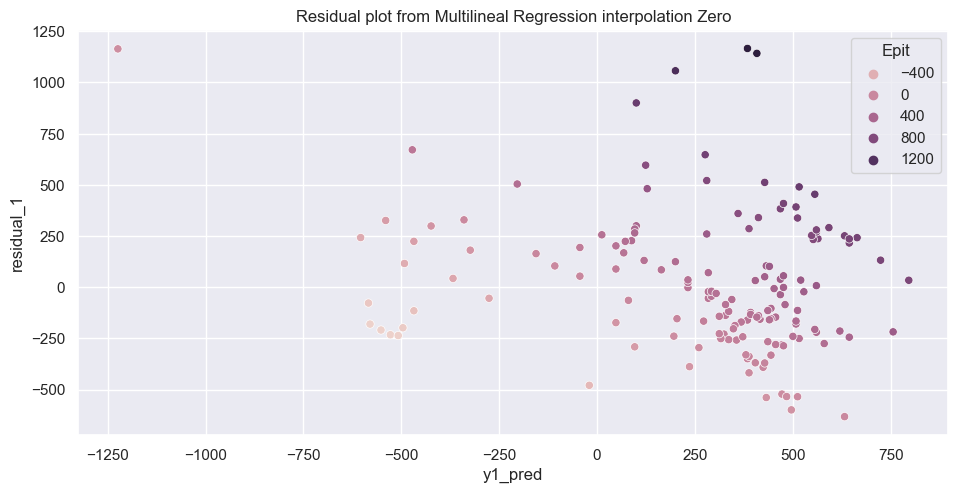

In [ ]:
sns.scatterplot(x=y_pred, y=residual_1, hue=y1_test)
plt.xlabel('y1_pred')
plt.ylabel('residual_1')
plt.title('Residual plot from Multilineal Regression interpolation Zero');

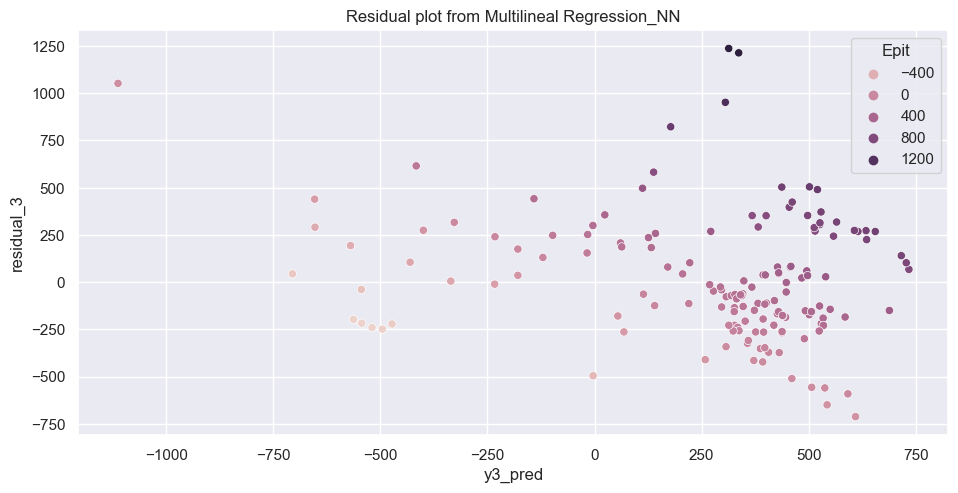

In [ ]:
residual_3 = y3_test - y3_pred
#compute mean residuals
np.mean(residual_3)

sns.scatterplot(x=y3_pred, y=residual_3, hue=y3_test)
plt.xlabel('y3_pred')
plt.ylabel('residual_3')
plt.title('Residual plot from Multilineal Regression_NN');

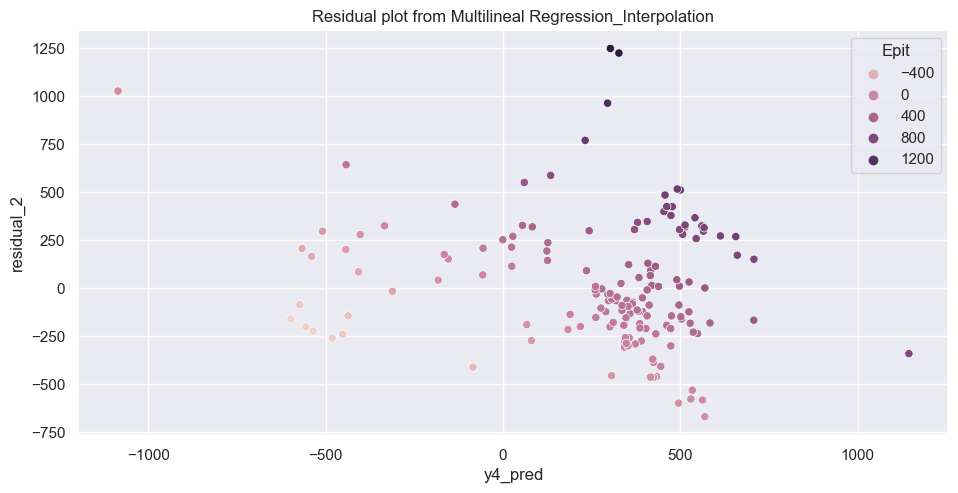

In [ ]:
residual_4 = y4_test - y4_pred
#compute mean residuals
np.mean(residual_4)

sns.scatterplot(x=y4_pred, y=residual_4, hue=y4_test)
plt.xlabel('y4_pred')
plt.ylabel('residual_2')
plt.title('Residual plot from Multilineal Regression_Interpolation');

In [ ]:
Alloy_Mat=pd.concat([Alloy_Null.Material, Alloy_Inter], axis=1)
Alloy_Mat.round(2)
Alloy_Mat.to_csv("../data/Alloy_Mat.csv", index=False)